## **Problem 1**

### **Problem 1A**

_____________________________________**SKIPPED FOR SCRIBE NOTES**________________________

### **Problem 1B**

_____________________________________**SKIPPED FOR SCRIBE NOTES**________________________

### **Problem 1C**

_____________________________________**SKIPPED FOR SCRIBE NOTES**________________________

### **Extra Credit**

_____________________________________**SKIPPED FOR SCRIBE NOTES**________________________

## **Problem 2**

### **Problem 2A**

Write code to sample points from a recognizable but simple distribution in two dimensions

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Reproducibility
seed = 42
np.random.seed(seed)
num_points = 1000
radius = 1.0
noise = 0.1

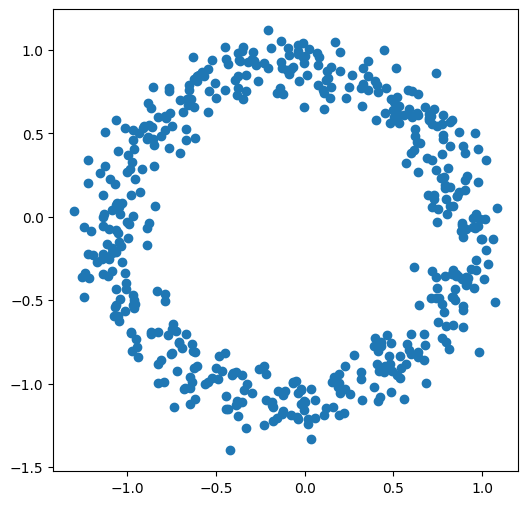

In [ ]:
# equation for a circle
def point(h, k, radius, noise):
  theta = np.random.uniform(0, 2*np.pi)
  x = h + radius*np.cos(theta) + np.random.normal(-noise, noise)
  y = k + radius*np.sin(theta) + np.random.normal(-noise, noise)
  return x, y

xy = np.zeros((num_points, 2))
for i in range(num_points):
  xy[i, :] = point(0, 0, radius, noise)

x = xy[:, 0]
y = xy[:, 1]
# make X_0 a tensor
X_0 = torch.tensor([x, y])

plt.figure(figsize=(6, 6))
plt.scatter(X_0[0], X_0[1])
plt.show()

### **Problem 2B**

Recall xt = √ αtx0 +√ 1 −αtz for z ∼ N(0,I). Write code to plot x0,x1,...,xT. Choose the number of steps T and the multiplicative weight α so that the images slowly turn to noise.

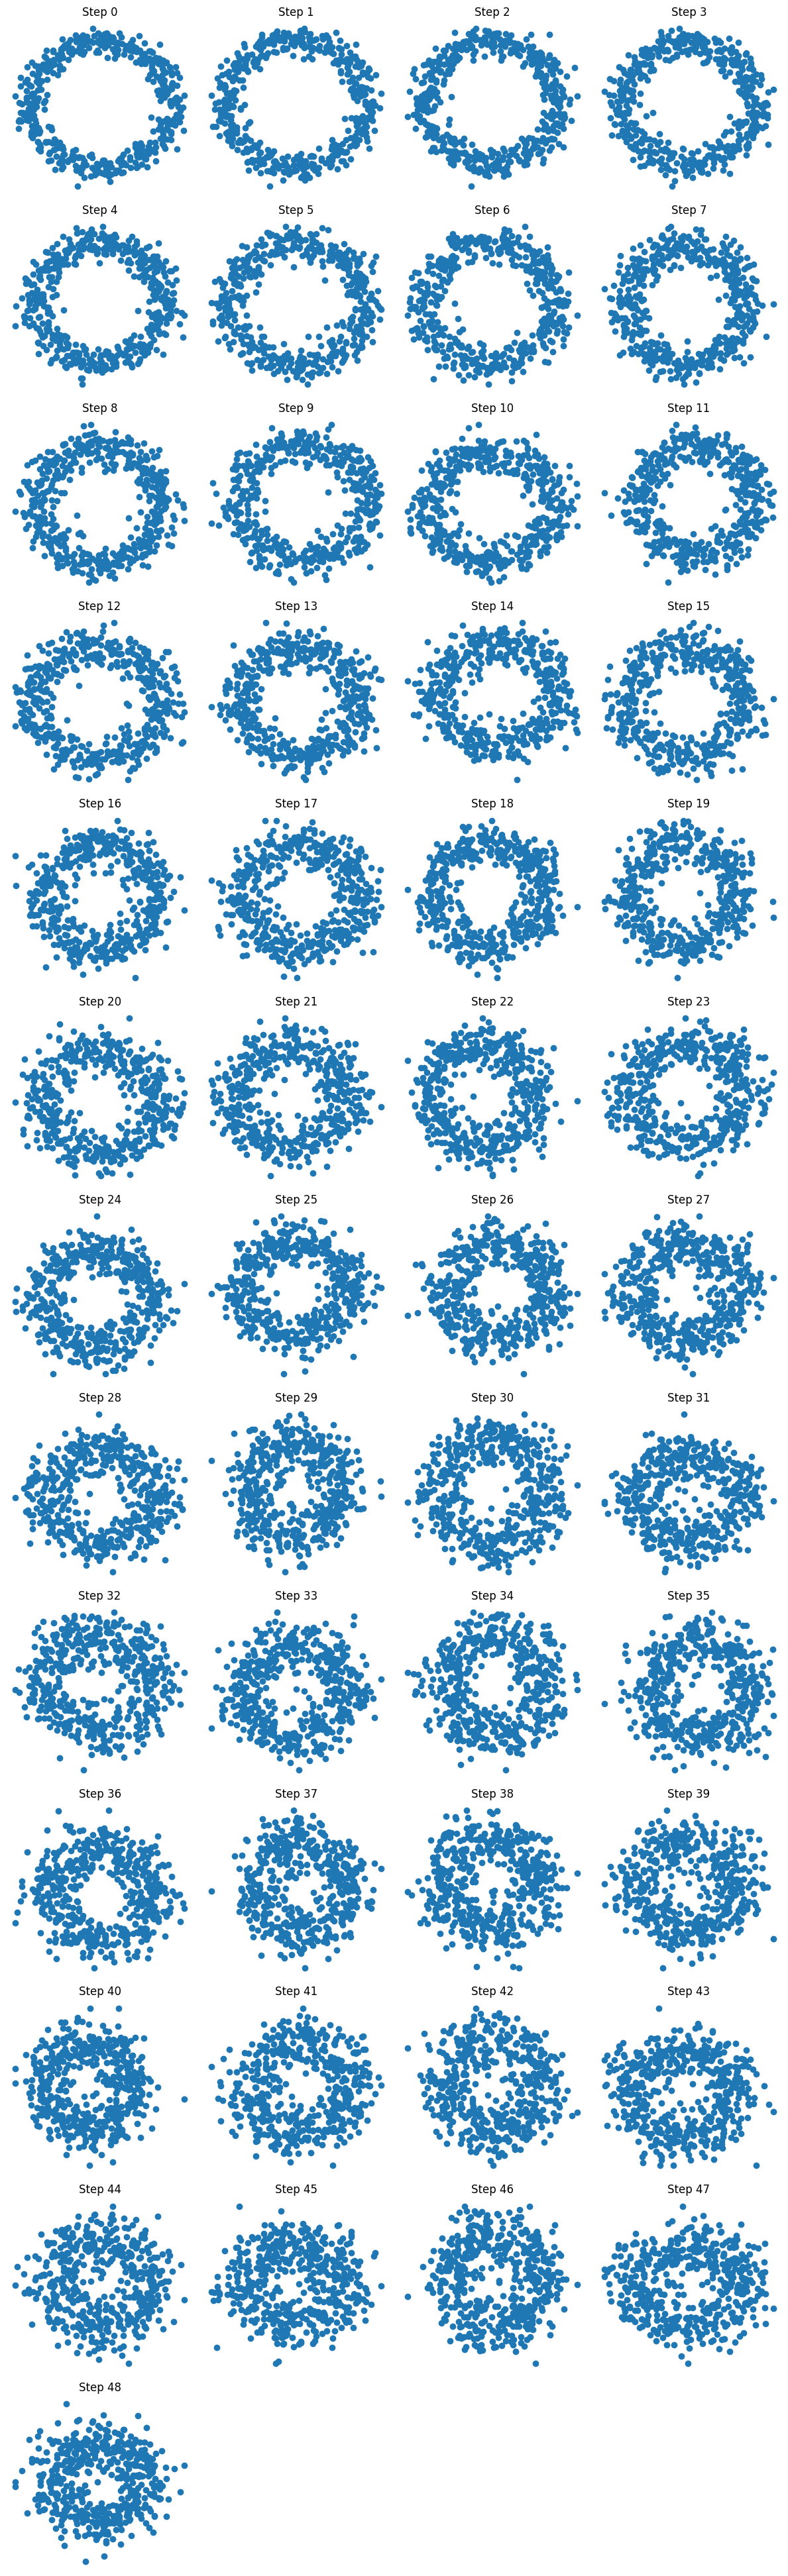

In [ ]:
def plot_noising(X_0, T, alpha):

  # Save all of X_0 through X_T
  X = []

  # Apply T times
  for t in range(T):

    # Calculate xt = √(αt)x_0 +√(1−α^t)z for z ∼ N(0,I)
    # sample Z from gaussian
    z = (np.random.normal(0, 1, X_0[0].shape),
         np.random.normal(0, 1, X_0[1].shape))
    alpha_t = alpha**t

    # Compute X_T for this time step
    X_T = (np.sqrt(alpha_t) * X_0[0] + np.sqrt(1 - alpha_t) * z[0],
           np.sqrt(alpha_t) * X_0[1] + np.sqrt(1 - alpha_t) * z[1])
    X.append(X_T)
  return X

T = 49
alpha = 0.998

X = plot_noising(X_0, T, alpha)

rows = (T + 3) // 4 # rows
plt.figure(figsize=(12, 3 * rows))

for i in range(T):
    plt.subplot(rows, 4, i + 1)
    plt.scatter(X[i][0], X[i][1])
    plt.title(f"Step {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### **Problem 2C**

Initialize a several layer neural network (both your input and output should be in R2). Train your diffusion model to predict the corresponding z for a given xt. Carefully tune your learning rate so the loss consistently decreases.

In [ ]:
class DiffusionModel(torch.nn.Module):
    def __init__(self, input_size=2):
        super(DiffusionModel, self).__init__()
        self.layer1 = self.layer(input_size, 64)
        self.layer2 = self.layer(64, 128)
        self.layer3 = torch.nn.Linear(128, 2)

    def layer(self, in_features, out_features):
        return torch.nn.Sequential(
            torch.nn.Linear(in_features, out_features),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

In [ ]:
def point(h, k, radius, noise):
    theta = np.random.uniform(0, 2 * np.pi)
    x = h + radius * np.cos(theta) + np.random.normal(-noise, noise)
    y = k + radius * np.sin(theta) + np.random.normal(-noise, noise)
    return x, y

def generate_X_0(num_points, radius, noise):
    xy = np.zeros((num_points, 2))
    for i in range(num_points):
        xy[i, :] = point(0, 0, radius, noise)
    X_0 = torch.tensor(xy, dtype=torch.float32)
    return X_0

In [ ]:
def one_hot_encode(t, T, n):
  one_hot = np.zeros((n, T))
  one_hot[np.arange(n), t] = 1
  return one_hot

In [ ]:
# Hyperparameters
# FOR O
radius = 1.0  # Radius of circle dist to sample from

# FOR X
length = 1

n_epochs = 200 #1000

num_X_0_per_epoch = 64  # number of X_0s to generate per epoch # 100
num_points_per = 1000 # number of points per X_0 #200
batch_size = 100  # Batch size used per X_T
noise = 0.1  # Degree of noise to introduce in sampling X_0
T = 49
alpha = 0.998
lr = 0.0001

100%|██████████| 100/100 [03:18<00:00,  1.98s/it]


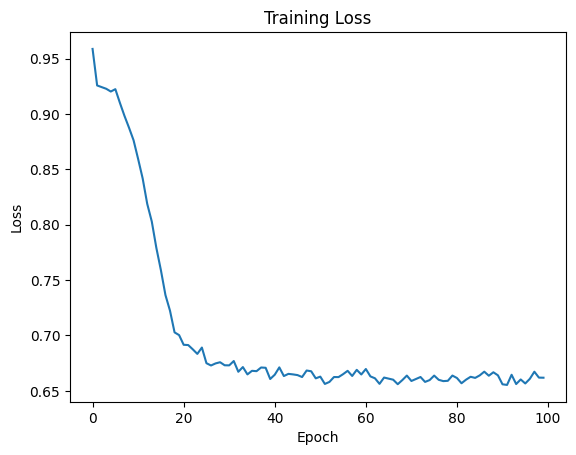

In [ ]:
# Initialize model, loss, optimizer
model = DiffusionModel(input_size=2 + T+1) # + T
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)

losses = []
for epoch in tqdm(range(n_epochs)):
    model.train()
    epoch_loss = 0

    for _ in range(num_X_0_per_epoch):
        # Generate a new X_0 for this subset
        X_0 = generate_X_0(num_points_per, radius, noise)

        for b in range(0, num_points_per, batch_size):
            # Batch of points for X_T
            X_0_batch = X_0[b:b + batch_size]
            t = torch.randint(0, T + 1, (X_0_batch.shape[0], 1))

            # One-hot encode t
            t_one_hot = one_hot_encode(t, T + 1, X_0_batch.shape[0])
            t_one_hot = torch.tensor(t_one_hot, dtype=torch.float32)

            # Sample z ~ N(0, I) and compute X_t = sqrt(alpha^t) * X_0 + sqrt(1 - alpha^t) * z
            z = torch.randn_like(X_0_batch)
            alpha_t = torch.pow(alpha, t.float())
            sqrt_alpha_t = torch.sqrt(alpha_t)
            sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)
            X_t = sqrt_alpha_t * X_0_batch + sqrt_one_minus_alpha_t * z

            # Concatenate X_t and one-hot encoded t
            X_t = torch.cat((X_t, t_one_hot), dim=1)

            # Predict z from X_t using the model + compute loss:
            # MSE between predicted and true z
            pred = model(X_t)
            loss = loss_fn(pred, z)
            optim.zero_grad()
            loss.backward()
            optim.step()
            epoch_loss += loss.item()

    # Compute average loss for the epoch
    epoch_loss /= (num_X_0_per_epoch * num_points_per / batch_size)
    losses.append(epoch_loss)

# Plot the training loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


### **Problem 2D**

In your training loop (every say 10 iterations), sample xT ∼ N(0,I) and repeatedly diffuse to x0 as described in class. Plot the resulting process and ensure your model learns the distribution!

In [ ]:
# Function to evaluate (reverse diffusion process)
def evaluate(model, T, alpha, num_points_per, batch_size):
    # Start with X_T sampled from N(0, I) in shape (num_points_per, 2) for  #points per X_0*(x,y)
    X_T = torch.randn(num_points_per, 2)

    # List to hold X_T at each step for plotting
    X_T_history = [X_T.clone().detach()]

    # Perform reverse diffusion for T steps
    for t_idx in reversed(range(T)):
        t = torch.full((X_T.shape[0], 1), t_idx, dtype=torch.int64)
        t_one_hot = one_hot_encode(t, T + 1, X_T.shape[0])
        t_one_hot = torch.tensor(t_one_hot, dtype=torch.float32)

        # Predict Z from the model
        Z_pred = model(torch.cat((X_T, t_one_hot), dim=1))
        #Z_pred = model(X_T)

        # Compute X_0 using the reverse process equation
        alpha_t = torch.pow(alpha, torch.tensor(t_idx, dtype=torch.float32))
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)

        X_0 = (X_T - sqrt_one_minus_alpha_t * Z_pred) / sqrt_alpha_t

        # Sample Z ~ N(0, I)
        Z = torch.randn_like(X_0)

        # Update X_T using the forward process equation
        X_T = sqrt_alpha_t * X_0 + sqrt_one_minus_alpha_t * Z
        X_T_history.append(X_T.clone().detach())

    return X_T_history

  2%|▏         | 9/500 [00:18<17:35,  2.15s/it]

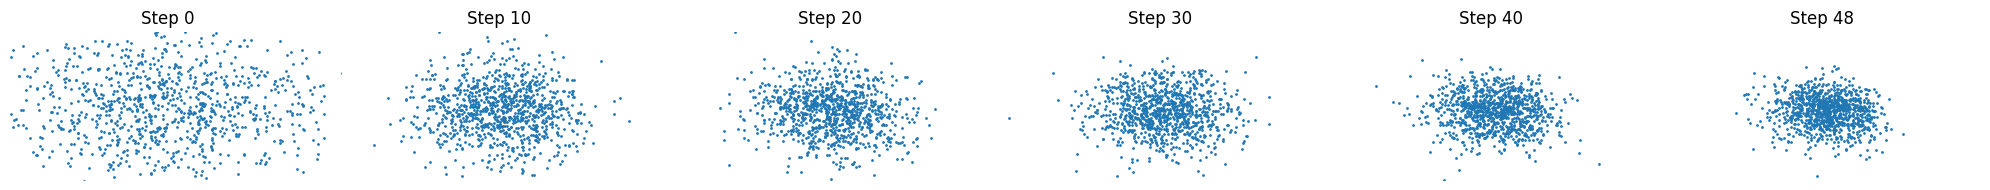

  4%|▍         | 19/500 [00:42<17:33,  2.19s/it]

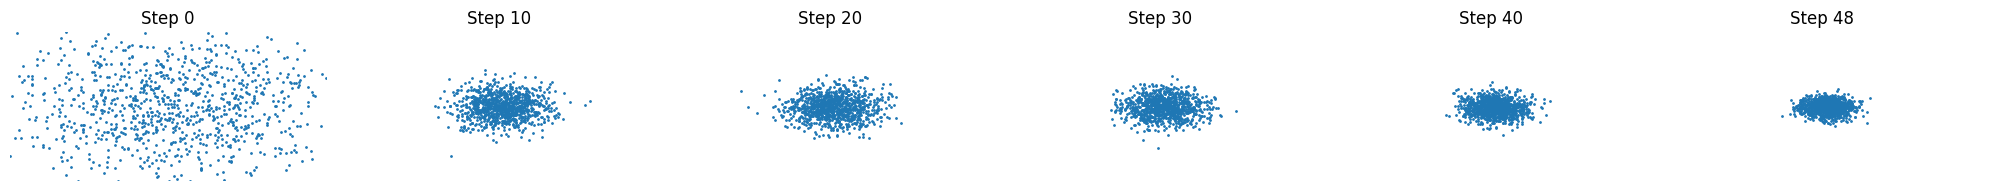

  6%|▌         | 29/500 [01:02<16:30,  2.10s/it]

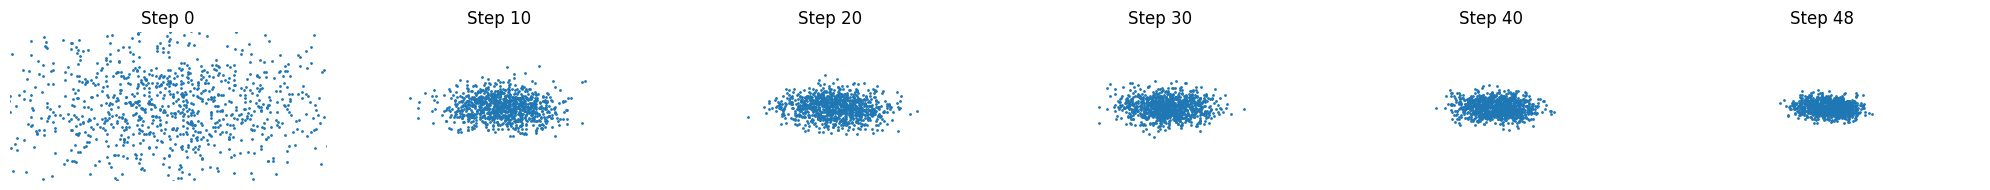

  8%|▊         | 39/500 [01:22<14:16,  1.86s/it]

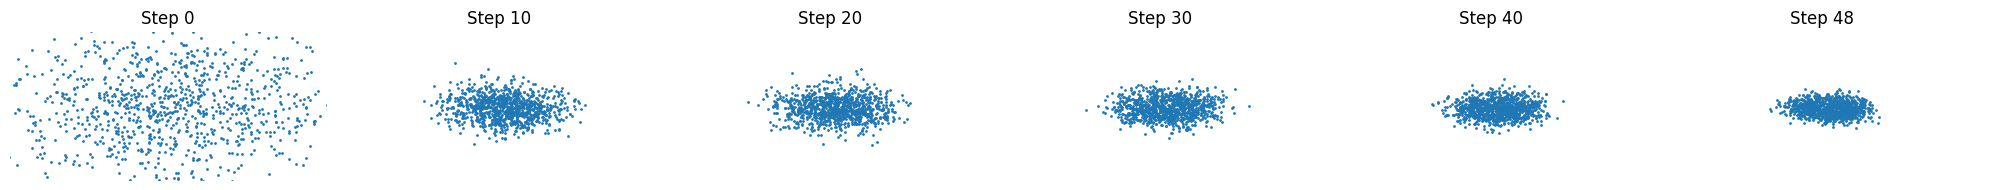

 10%|▉         | 49/500 [01:43<15:21,  2.04s/it]

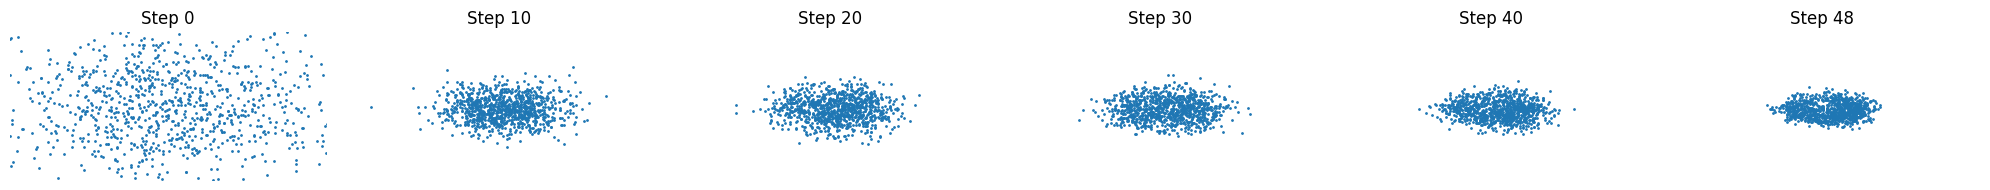

 12%|█▏        | 59/500 [02:04<15:08,  2.06s/it]

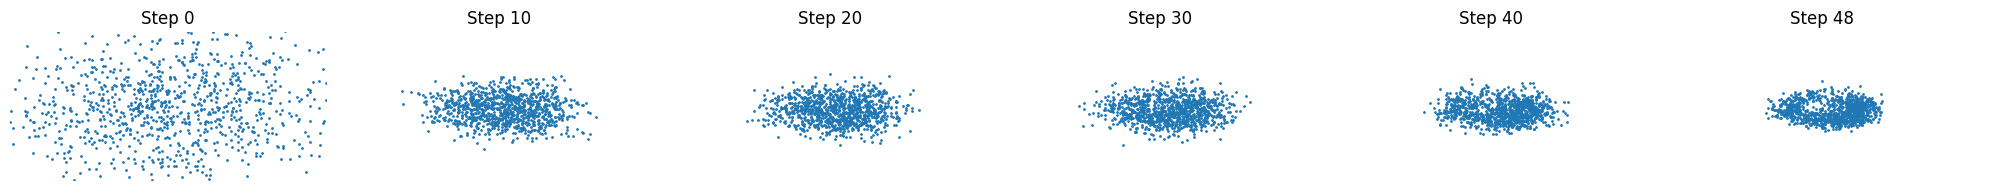

 14%|█▍        | 69/500 [02:25<14:13,  1.98s/it]

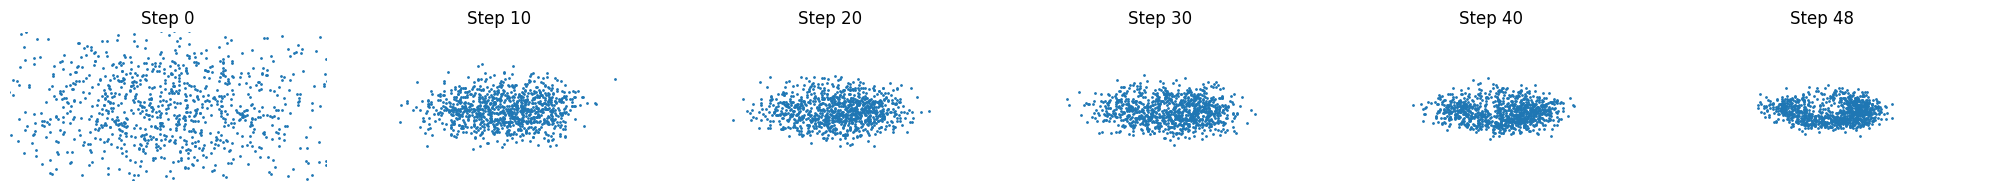

 16%|█▌        | 79/500 [02:46<14:48,  2.11s/it]

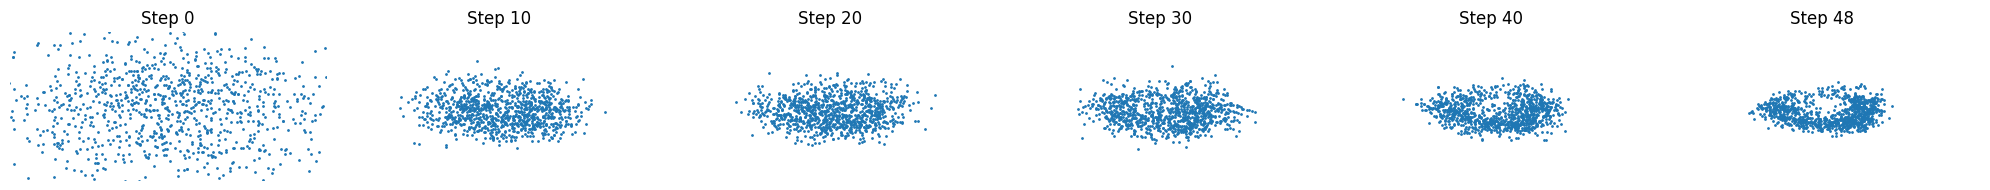

 18%|█▊        | 89/500 [03:06<12:55,  1.89s/it]

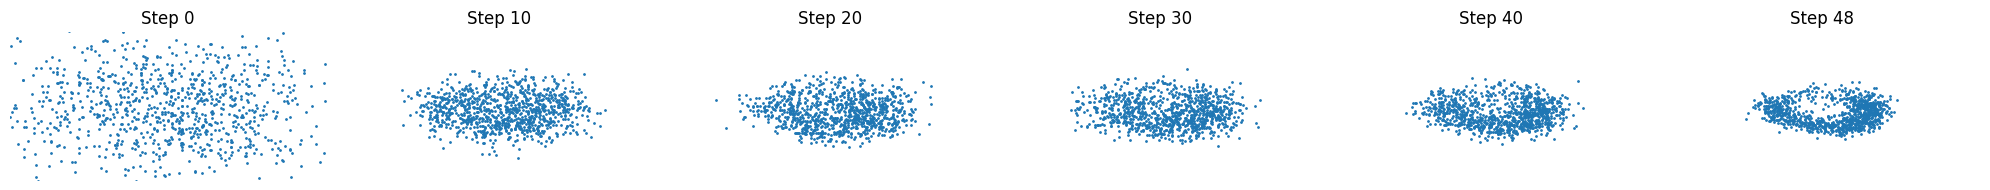

 20%|█▉        | 99/500 [03:28<14:20,  2.15s/it]

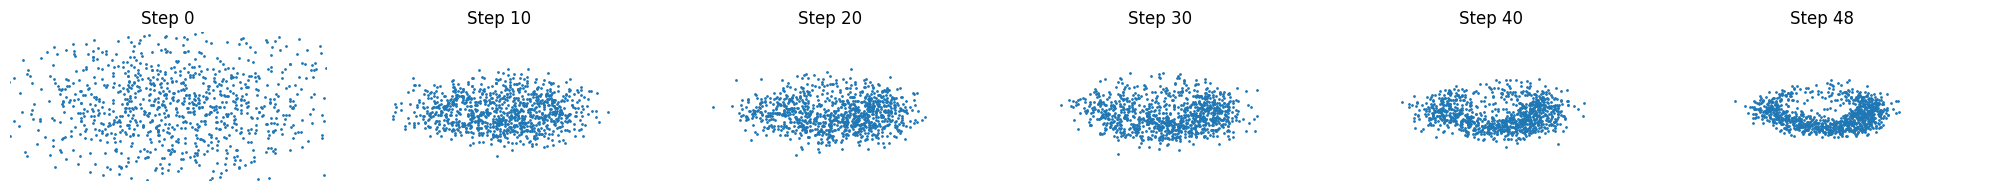

 22%|██▏       | 109/500 [03:50<14:02,  2.15s/it]

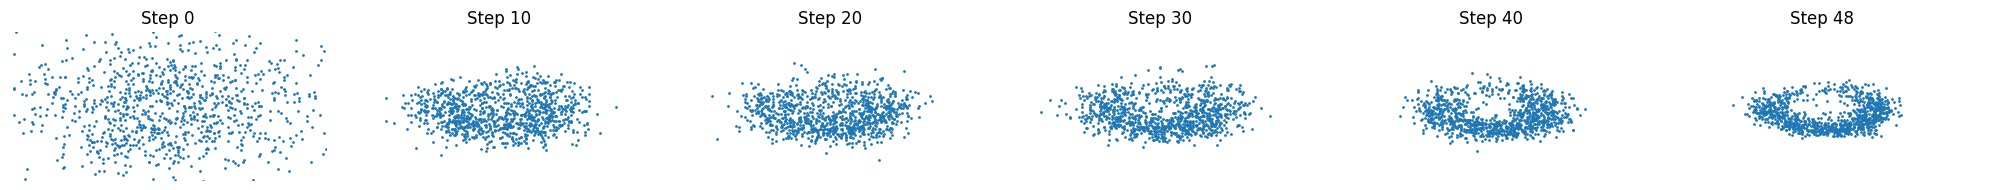

 24%|██▍       | 119/500 [04:10<12:12,  1.92s/it]

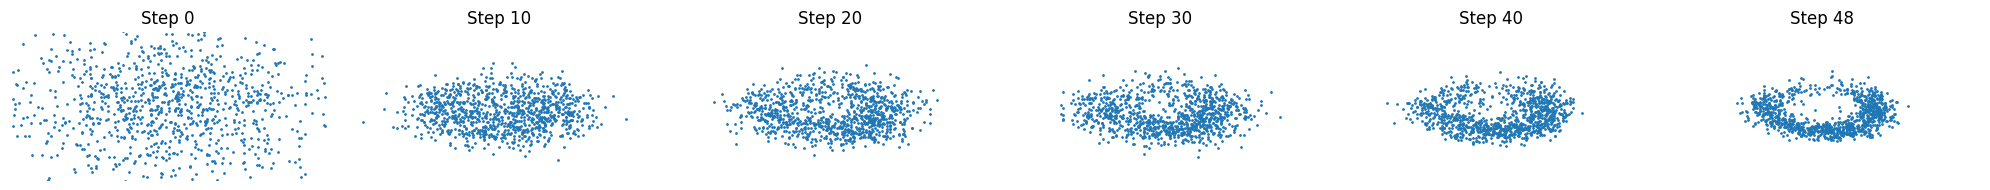

 26%|██▌       | 129/500 [04:31<12:57,  2.10s/it]

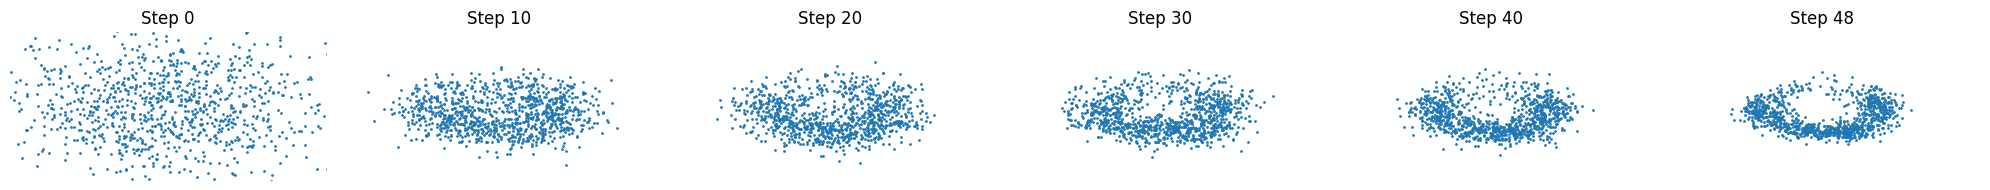

 28%|██▊       | 139/500 [04:52<11:44,  1.95s/it]

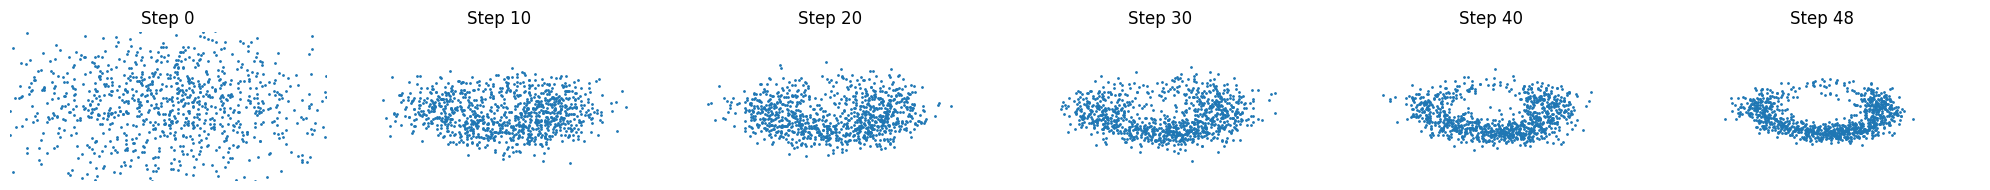

 30%|██▉       | 149/500 [05:13<11:53,  2.03s/it]

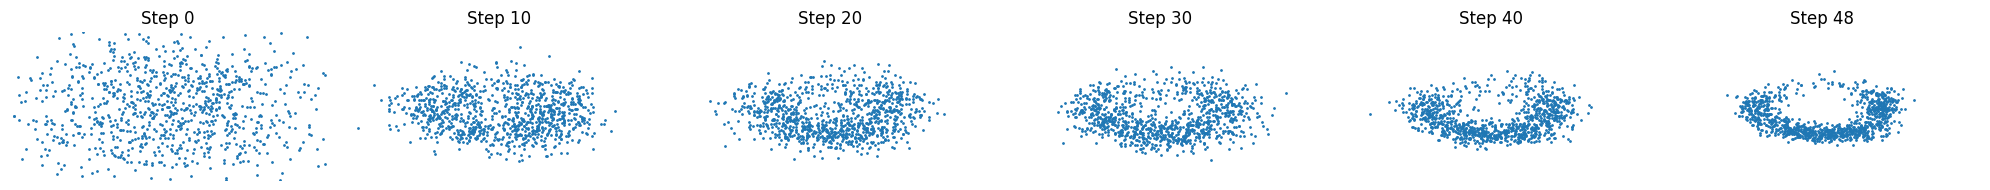

 32%|███▏      | 159/500 [05:34<12:00,  2.11s/it]

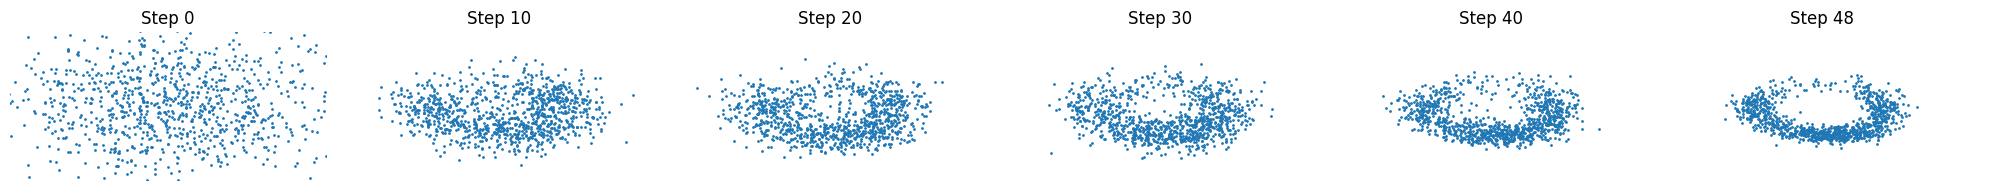

 34%|███▍      | 169/500 [05:55<10:43,  1.94s/it]

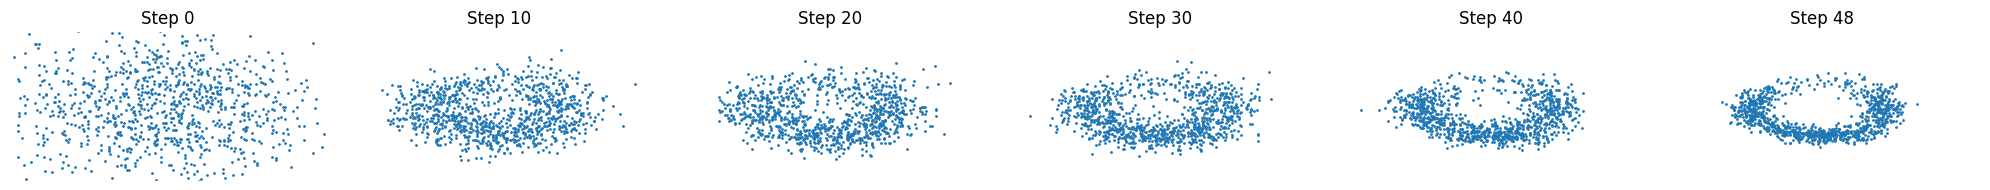

 36%|███▌      | 179/500 [06:16<11:07,  2.08s/it]

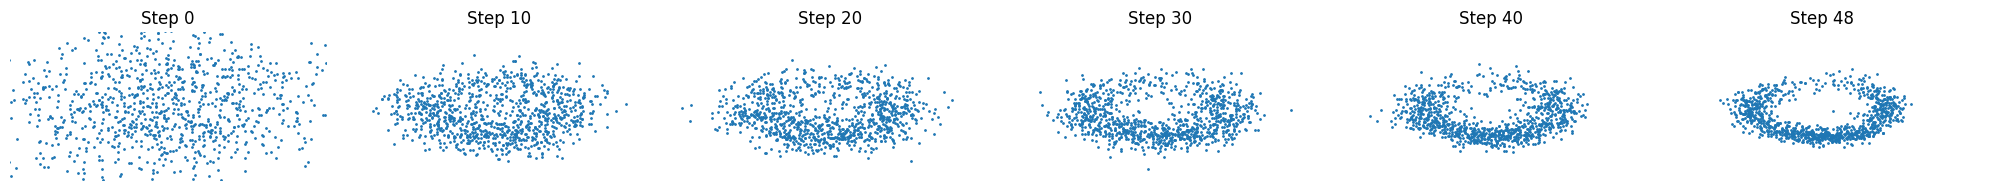

 38%|███▊      | 189/500 [06:37<10:03,  1.94s/it]

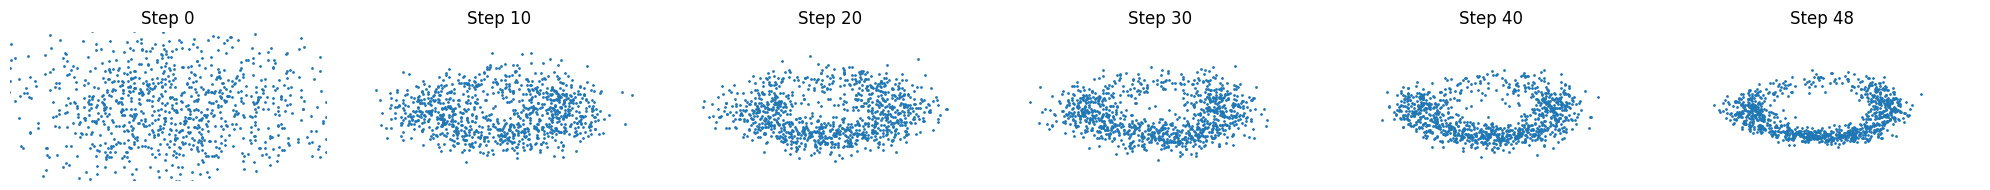

 40%|███▉      | 199/500 [06:59<09:55,  1.98s/it]

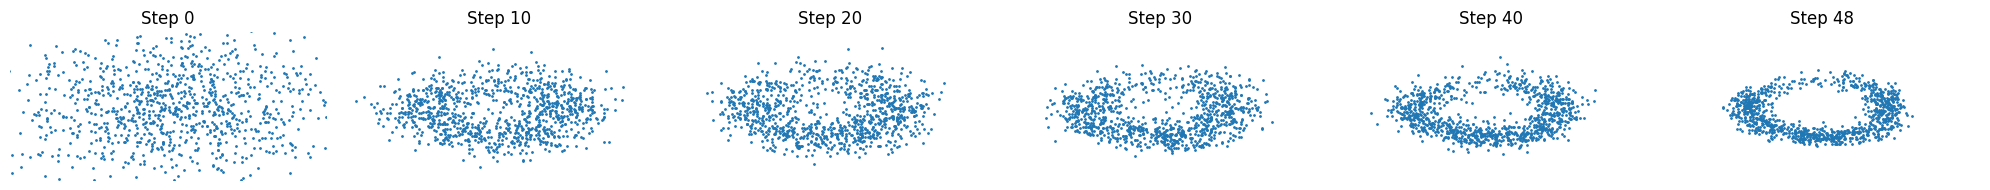

 42%|████▏     | 209/500 [07:20<10:18,  2.12s/it]

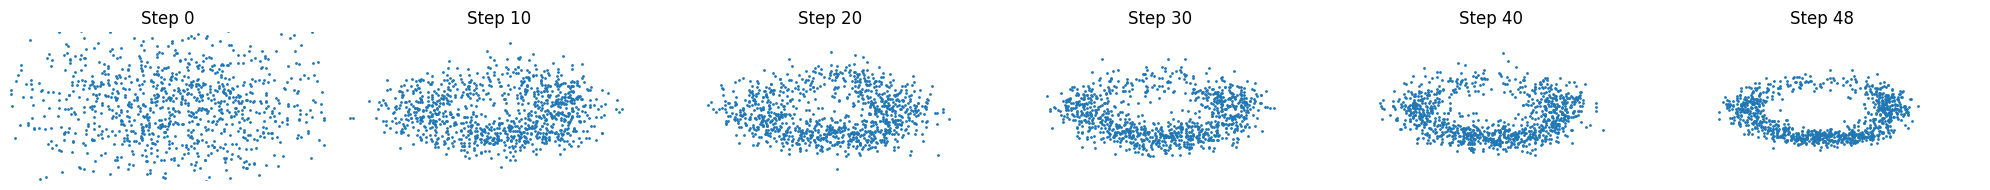

 44%|████▍     | 219/500 [07:40<08:48,  1.88s/it]

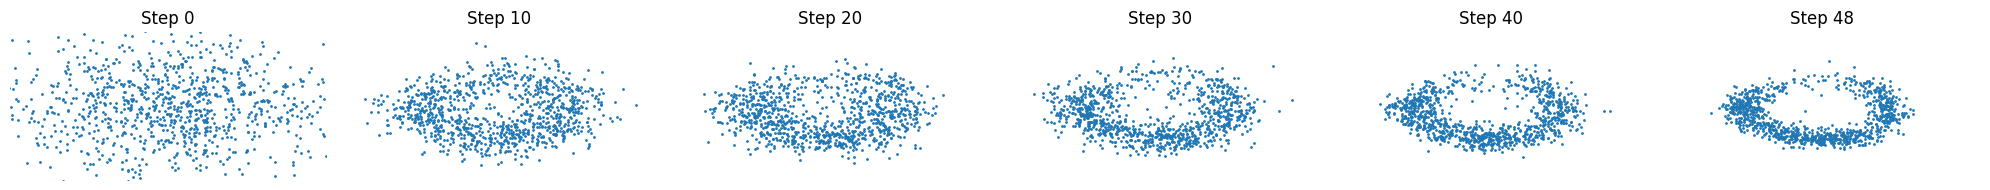

 46%|████▌     | 229/500 [08:01<09:22,  2.08s/it]

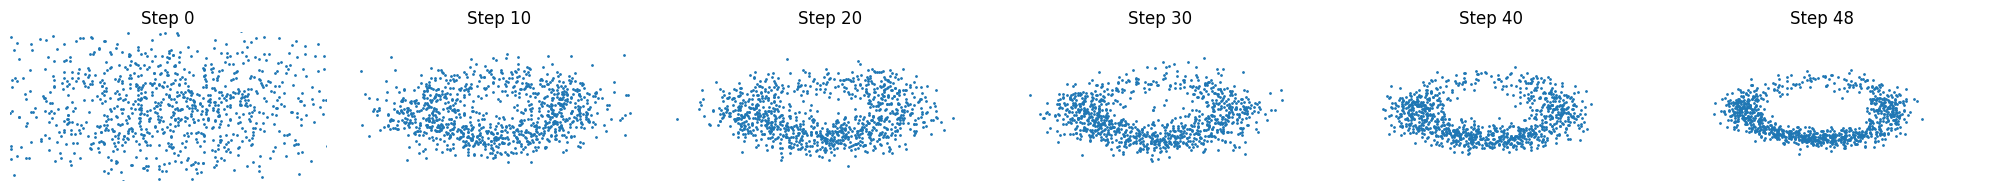

 48%|████▊     | 239/500 [08:21<08:05,  1.86s/it]

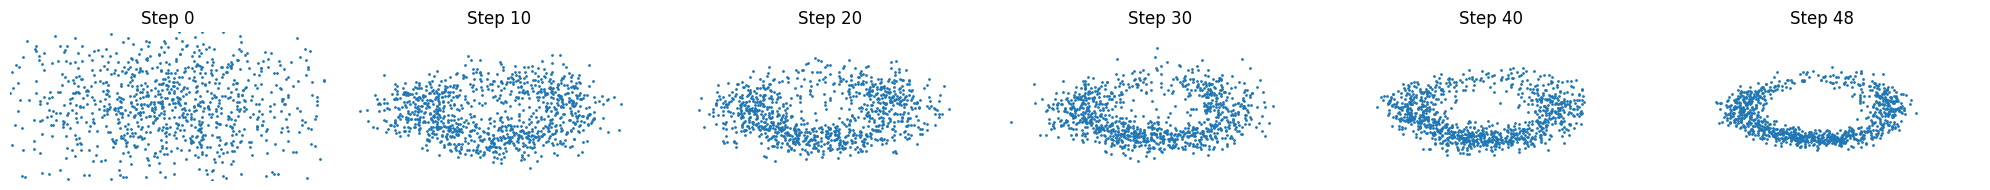

 50%|████▉     | 249/500 [08:42<08:05,  1.93s/it]

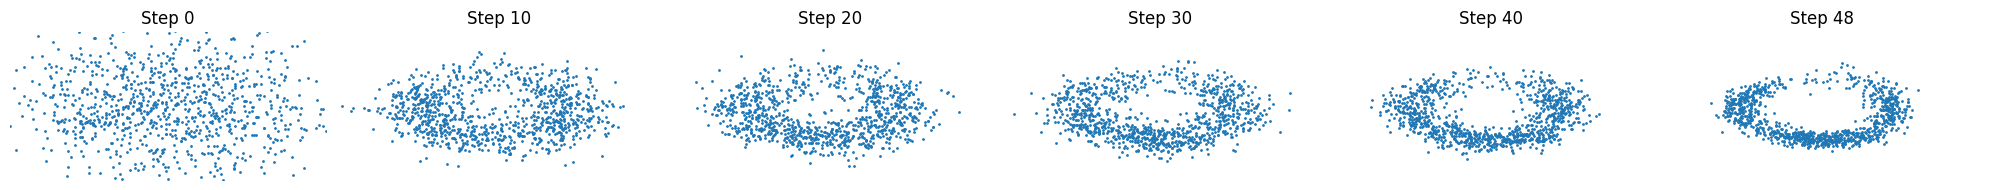

 52%|█████▏    | 259/500 [09:03<08:44,  2.18s/it]

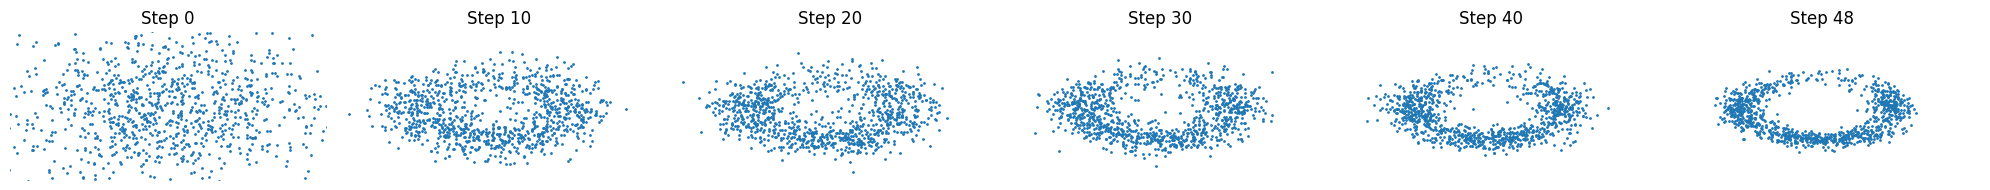

 54%|█████▍    | 269/500 [09:23<07:32,  1.96s/it]

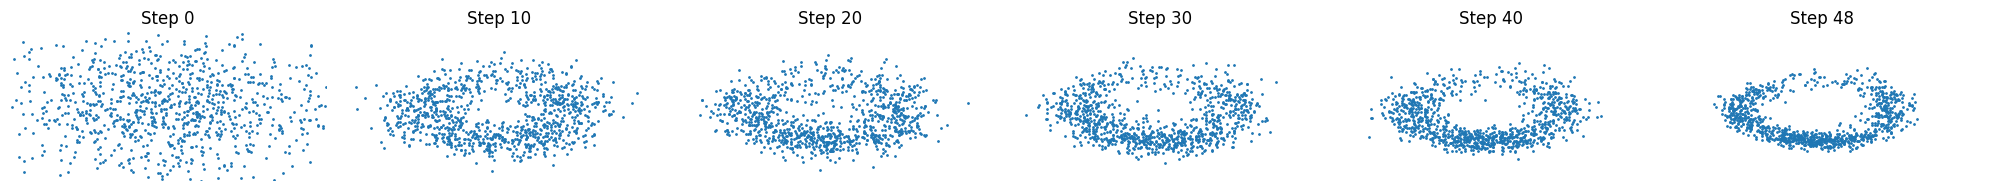

 56%|█████▌    | 279/500 [09:45<07:56,  2.15s/it]

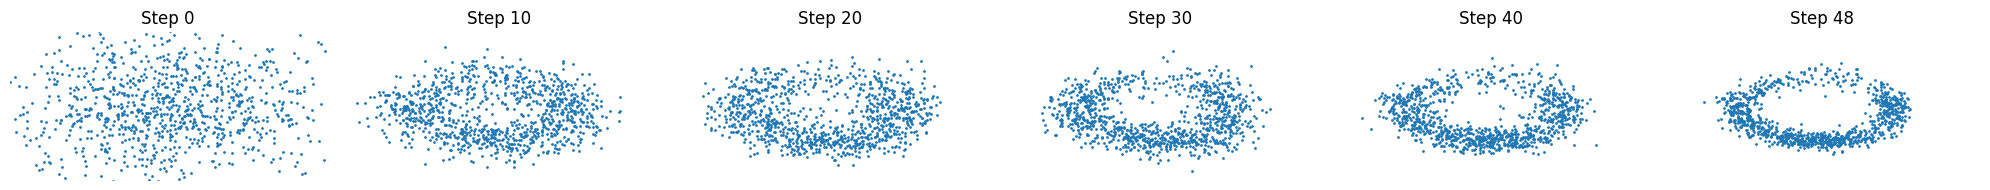

 58%|█████▊    | 289/500 [10:07<07:32,  2.15s/it]

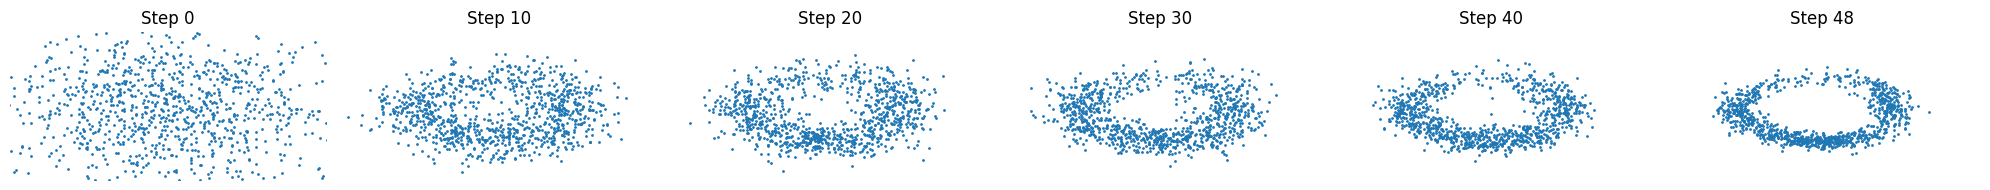

 60%|█████▉    | 299/500 [10:29<06:47,  2.03s/it]

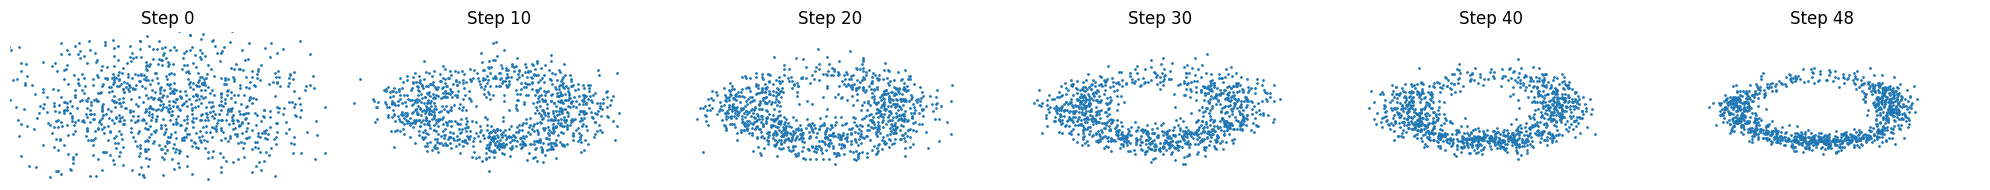

 62%|██████▏   | 309/500 [10:50<06:45,  2.12s/it]

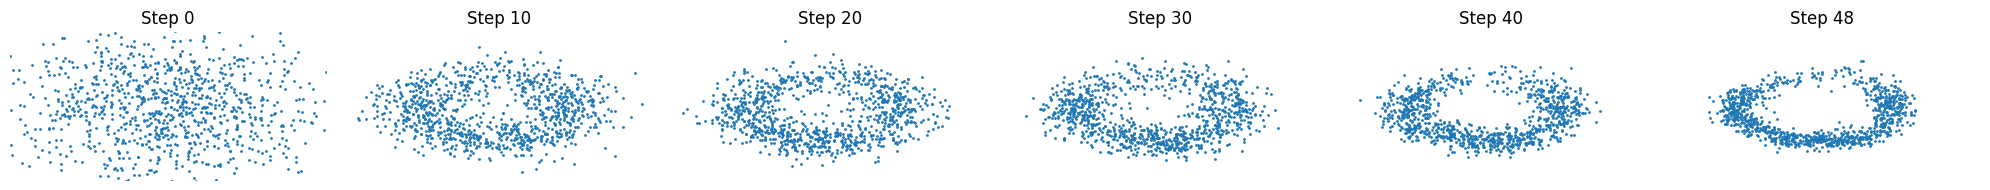

 64%|██████▍   | 319/500 [11:11<06:06,  2.03s/it]

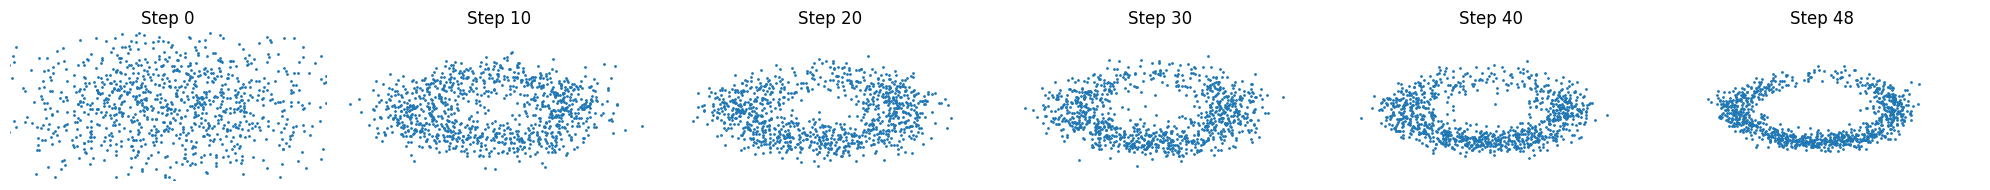

 66%|██████▌   | 329/500 [11:33<05:44,  2.01s/it]

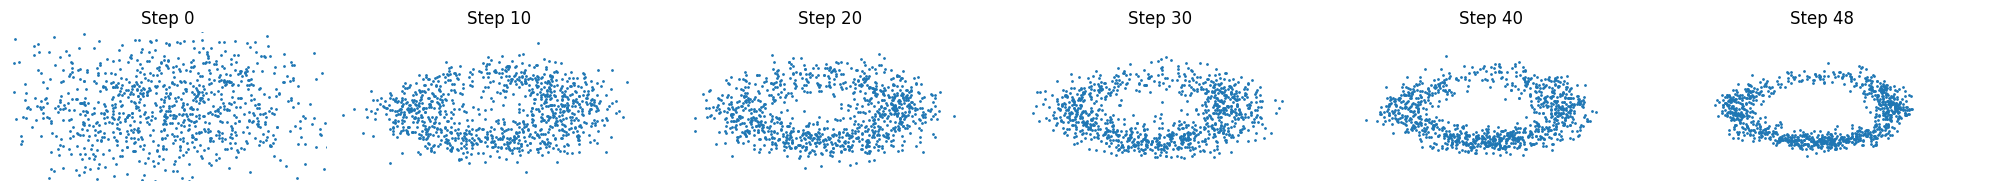

 68%|██████▊   | 339/500 [11:55<05:49,  2.17s/it]

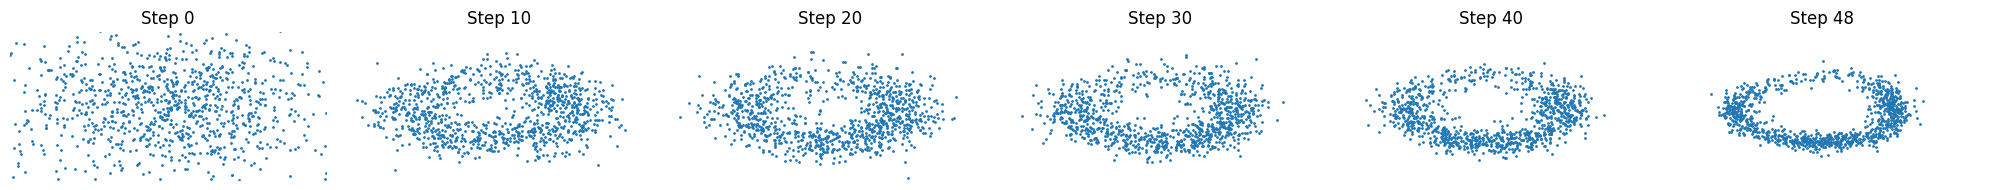

 70%|██████▉   | 349/500 [12:17<05:24,  2.15s/it]

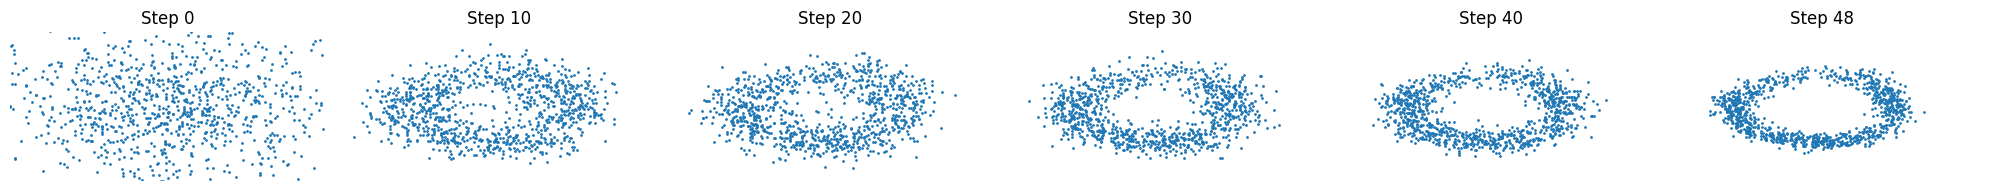

 72%|███████▏  | 359/500 [12:40<04:59,  2.13s/it]

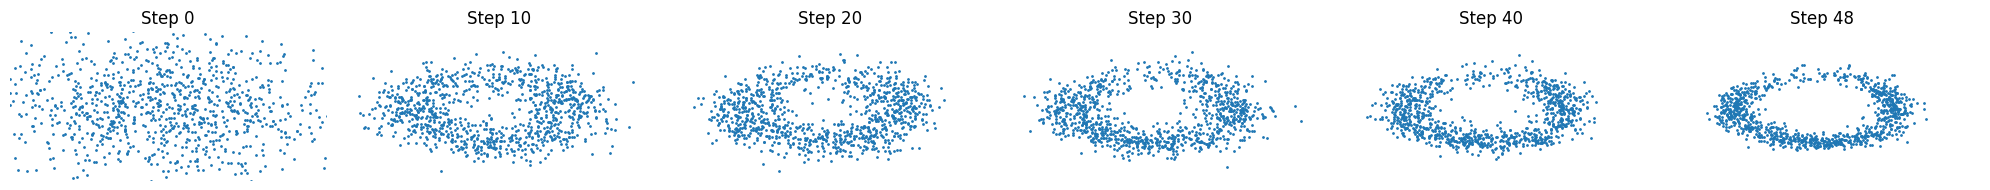

 74%|███████▍  | 369/500 [13:02<04:30,  2.07s/it]

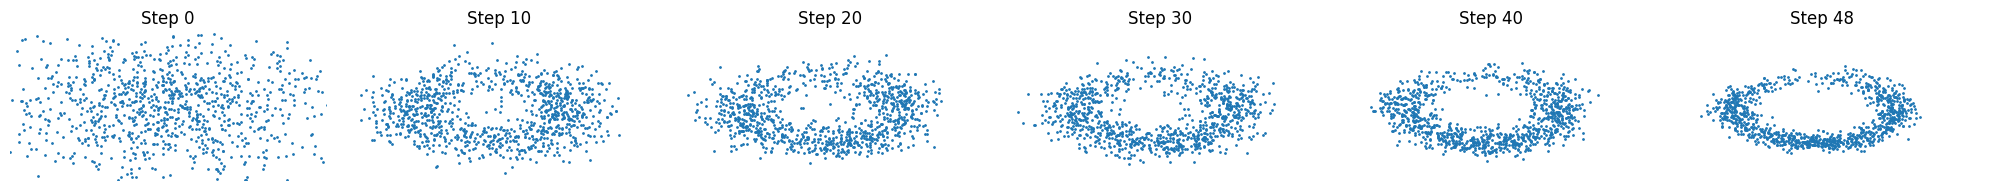

 76%|███████▌  | 379/500 [13:24<04:36,  2.29s/it]

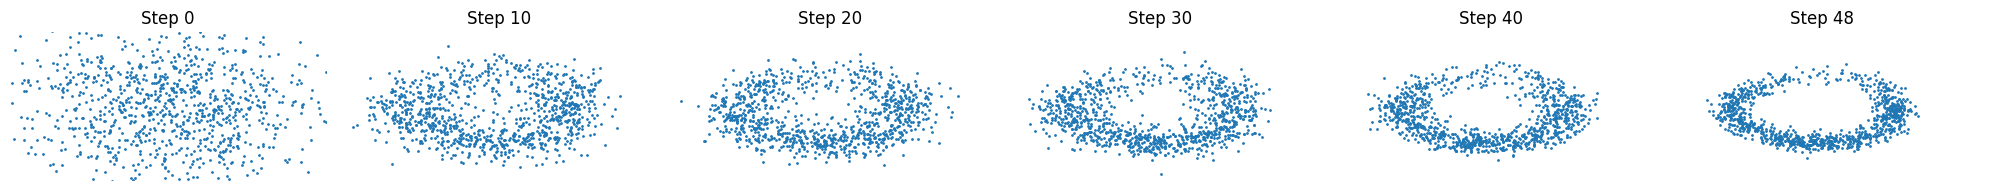

 78%|███████▊  | 389/500 [13:45<03:41,  1.99s/it]

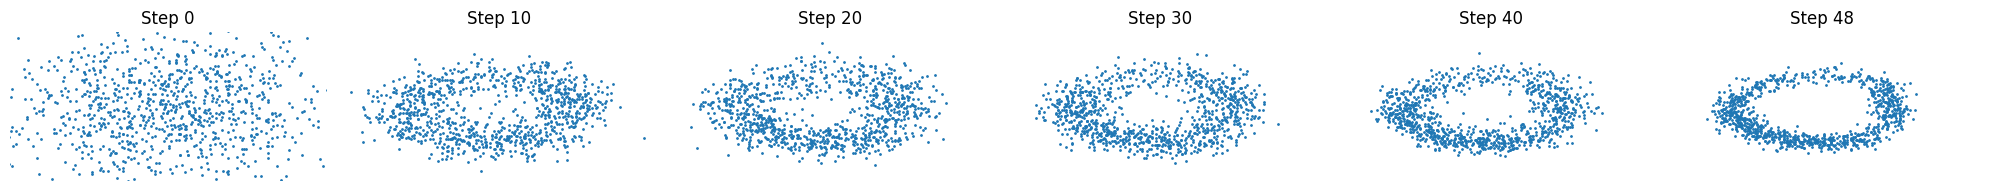

 80%|███████▉  | 399/500 [14:07<03:29,  2.08s/it]

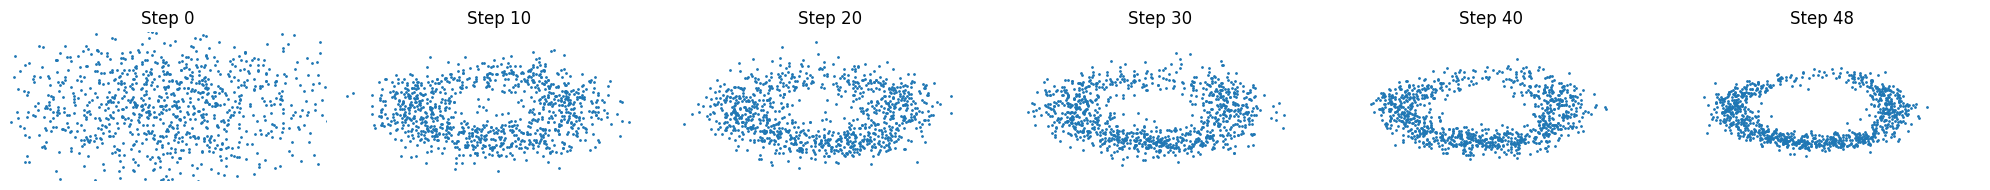

 82%|████████▏ | 409/500 [14:29<03:28,  2.29s/it]

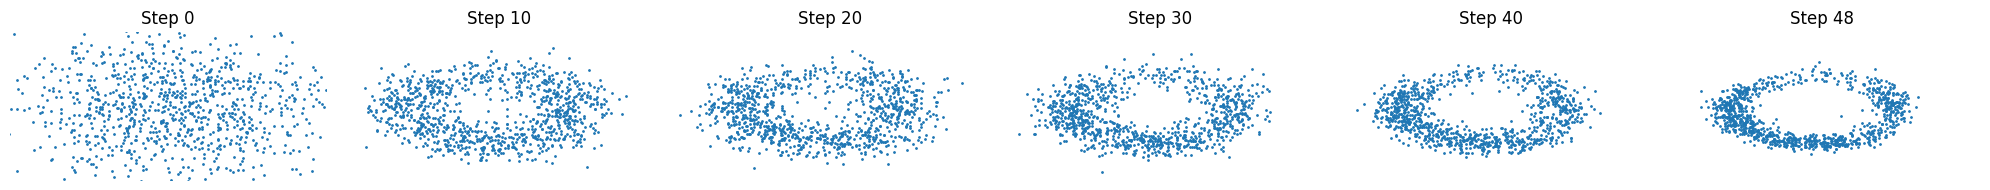

 84%|████████▍ | 419/500 [14:50<02:40,  1.98s/it]

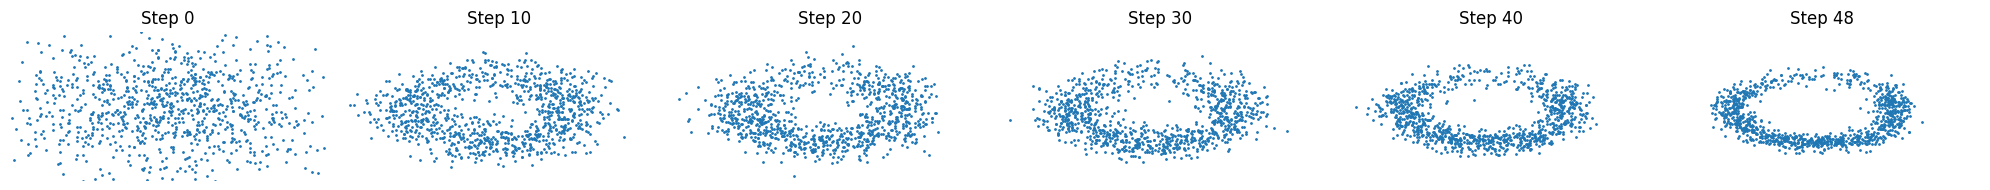

 86%|████████▌ | 429/500 [15:11<02:27,  2.08s/it]

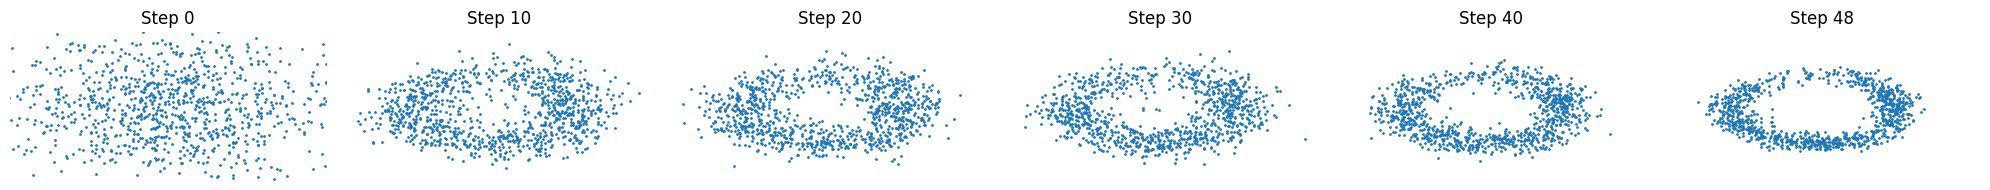

 88%|████████▊ | 439/500 [15:32<02:02,  2.01s/it]

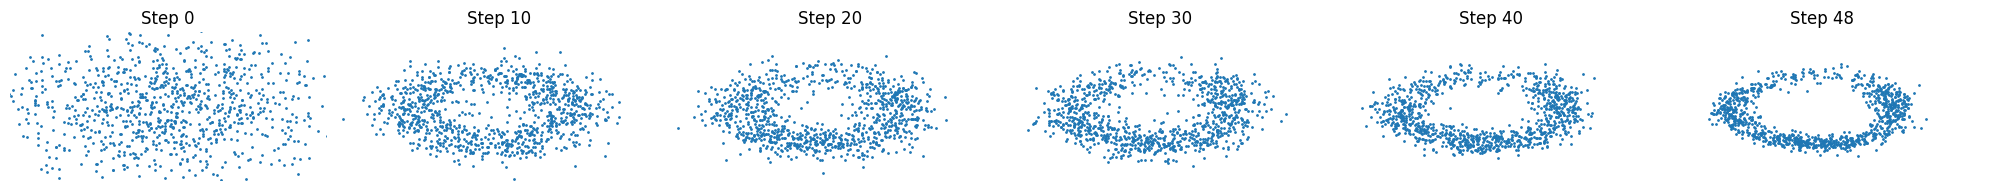

 90%|████████▉ | 449/500 [15:55<01:51,  2.18s/it]

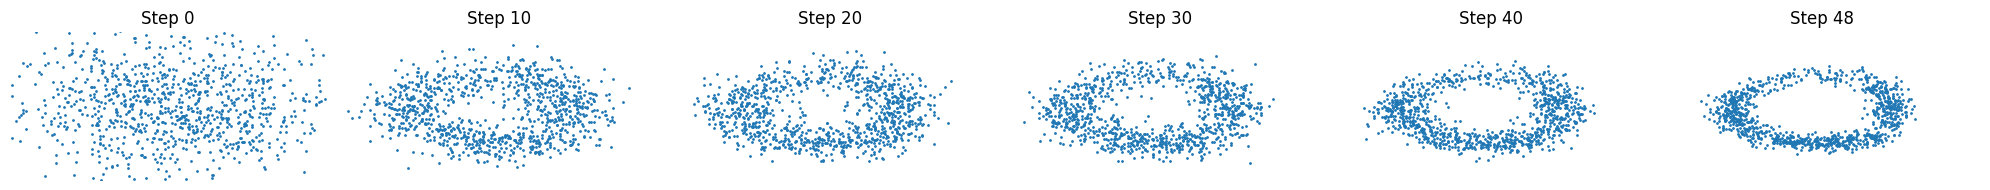

 92%|█████████▏| 459/500 [16:18<01:29,  2.19s/it]

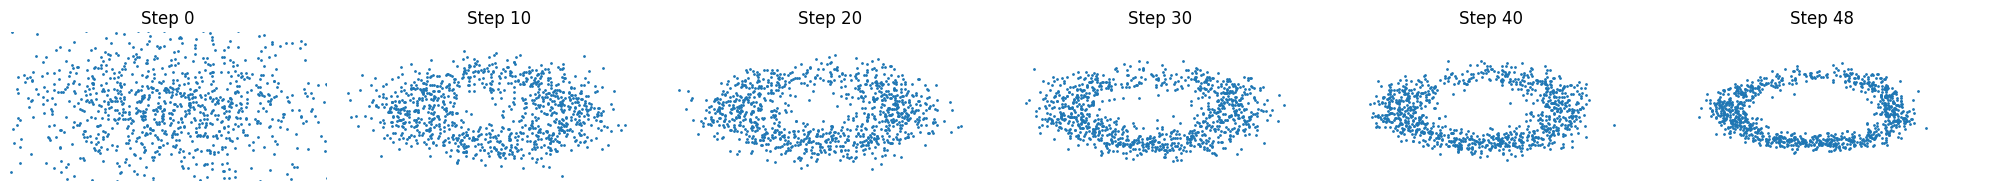

 94%|█████████▍| 469/500 [16:40<01:12,  2.33s/it]

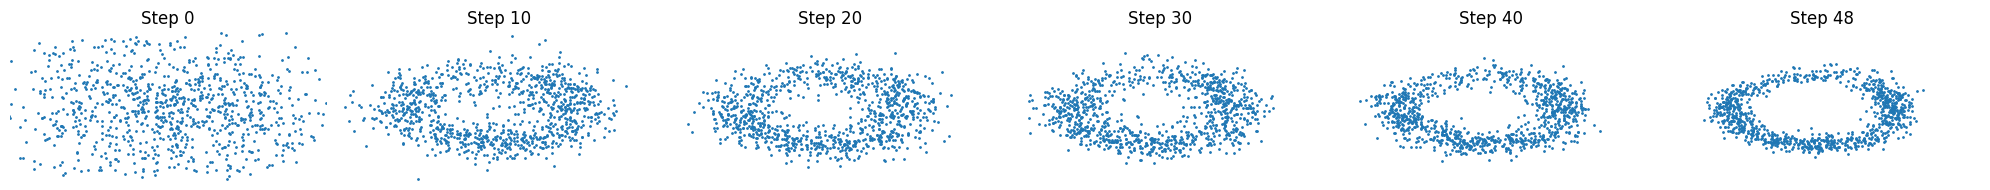

 96%|█████████▌| 479/500 [17:02<00:43,  2.07s/it]

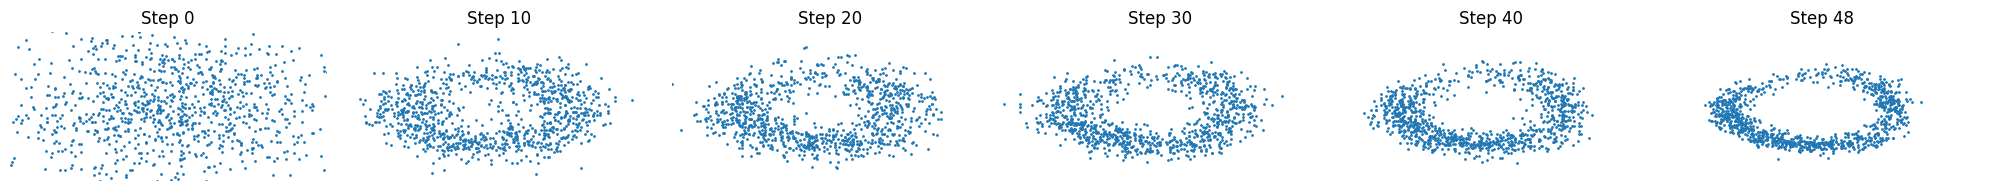

 98%|█████████▊| 489/500 [17:24<00:23,  2.15s/it]

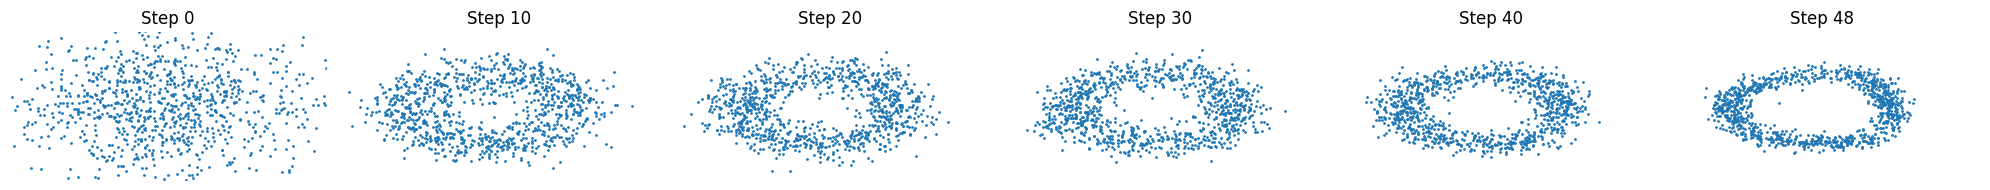

100%|█████████▉| 499/500 [17:47<00:02,  2.27s/it]

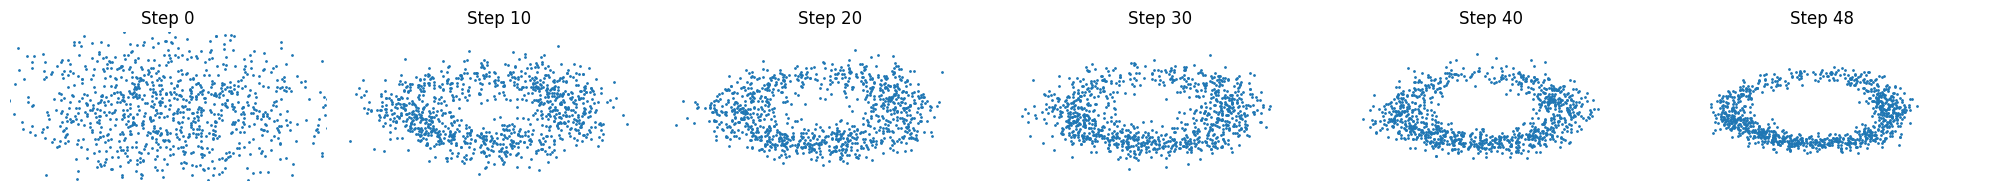

100%|██████████| 500/500 [17:50<00:00,  2.14s/it]


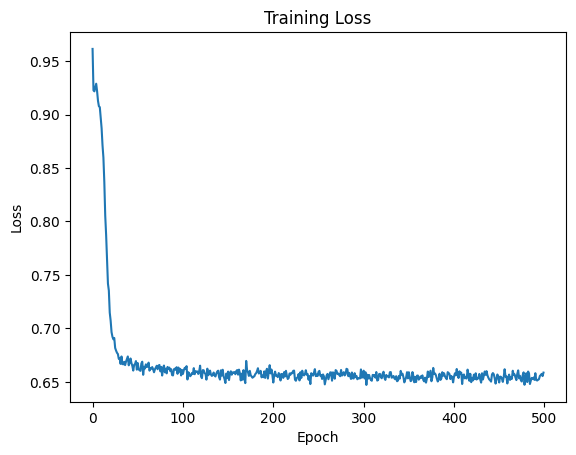

In [ ]:
# Initialize model, loss, optimizer
model = DiffusionModel(input_size=2 + T + 1) #+T + 1
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
losses = []
for epoch in tqdm(range(n_epochs)):
    model.train()
    epoch_loss = 0

    for _ in range(num_X_0_per_epoch):
        # Generate a new X_0 for this subset
        X_0 = generate_X_0(num_points_per, radius, noise)
        X_0 = X_0.float()

        for b in range(0, num_points_per, batch_size):
            # Batch of points for X_T
            X_0_batch = X_0[b:b + batch_size]
            t = torch.randint(0, T + 1, (X_0_batch.shape[0], 1))

            # One-hot encode t
            t_one_hot = one_hot_encode(t, T + 1, X_0_batch.shape[0])
            t_one_hot = torch.tensor(t_one_hot, dtype=torch.float32)

            # Sample z ~ N(0, I) and compute X_t = sqrt(alpha^t) * X_0 + sqrt(1 - alpha^t) * z
            z = torch.randn_like(X_0_batch)
            alpha_t = torch.pow(alpha, t.float())
            sqrt_alpha_t = torch.sqrt(alpha_t)
            sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)
            X_t = sqrt_alpha_t * X_0_batch + sqrt_one_minus_alpha_t * z

            # Concatenate X_t and one-hot encoded t
            X_t = torch.cat((X_t, t_one_hot), dim=1)

            # Predict z from X_t using the model + compute loss:
            # MSE between predicted and true z
            pred = model(X_t)
            loss = loss_fn(pred, z)
            optim.zero_grad()
            loss.backward()
            optim.step()
            epoch_loss += loss.item()

    # Loos
    epoch_loss /= (num_X_0_per_epoch * num_points_per / batch_size)
    losses.append(epoch_loss)

    # Evaluate every 10 epochs
    if (epoch + 1) % 10 == 0:
      X_T_history = evaluate(model, T, alpha, num_points_per, batch_size)
      plt.figure(figsize=(20, 2))
      num_steps = len(X_T_history)
      for step, X_T_step in enumerate(X_T_history):
        if step % 10 == 0 or step == T-1: # every 10th or last step
          steps_to_plot = list(range(0, T, 10)) + [T-1] # every 10th + the last
          num_plots = len(steps_to_plot)
          subplot_idx = steps_to_plot.index(step) + 1
          plt.subplot(1, num_plots, subplot_idx)
          plt.scatter(X_T_step[:, 0], X_T_step[:, 1], s=1, label=f"Step {step}")
          plt.xlim(-2, 2)
          plt.ylim(-2, 2)
          plt.axis('off')
          plt.title(f"Step {step}")

      plt.tight_layout()
      plt.show()

# Plot the training loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

## **Problem 3**

### **Problem 3A**

Create one distribution pdata that is a recognizable but simple distribution like two balls of points. Create another distribution pdata that is the first distribution but shifted.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

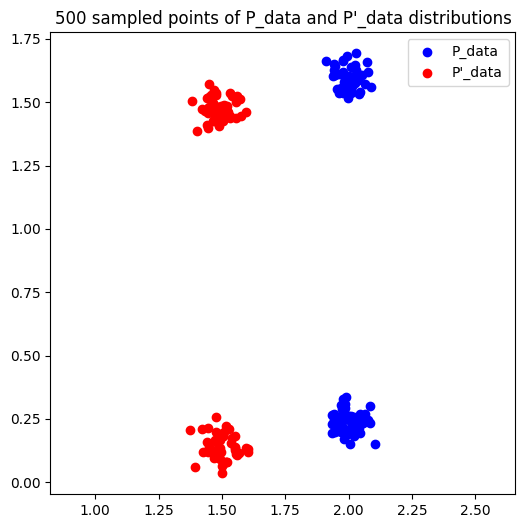

In [ ]:
cluster1_mean = (2, 1.6)
cluster2_var = 0.002
cluster_1_size = 50000

cluster2_mean = (2, 0.25)
cluster2_var = 0.002
cluster_2_size = 50000

# sample points for each cluster
cluster1 = np.random.multivariate_normal(cluster1_mean, np.eye(2) * cluster2_var, cluster_1_size)
cluster2 = np.random.multivariate_normal(cluster2_mean, np.eye(2) * cluster2_var, cluster_2_size)

# combine the clusters
pdata_np = np.concatenate([cluster1, cluster2])
np.random.shuffle(pdata_np)

# distribution2 is distribution1 but shifted
pdata_prime_np = pdata_np - np.array([cluster1_mean[0]/4, cluster2_mean[1]/2])
np.random.shuffle(pdata_prime_np)

plt.figure(figsize=(6, 6))
plt.scatter(pdata_np[:100, 0], pdata_np[:100, 1], color='blue', label='P_data')
plt.scatter(pdata_prime_np[:100, 0], pdata_prime_np[:100, 1], color='red', label="P'_data")
plt.axis('equal')
plt.title("500 sampled points of P_data and P'_data distributions")
plt.legend()
plt.show()

### **Problem 3B**

Set T ≈ 20 and γ =2/T. Using the simplified diffusion approach described in class, train a ‘forward’ model f to go from N(0,I) to pdata and a ‘backward’ model b to go from N(0,I) to p'data

In [ ]:
# Okay?
T=20
gamma=2/T

# As a tensor for training purposes
pdata_prime = torch.tensor(pdata_prime_np, dtype=torch.float32)
pdata = torch.tensor(pdata_np, dtype=torch.float32)

In [ ]:
def generate_Xs(T, p_data, p_prime_data):
  X = [p_data] # X_t from p_data to N(0, I)
  Y = [p_prime_data] # Y_t from p_prime_data to N(0, I)
  X_t = p_data
  Y_t = p_prime_data

  # apply noising at each timestep
  for t in range(T):
    z = torch.randn_like(p_data)
    z_prime = torch.randn_like(p_prime_data)

    X_t_plus_1 = X_t + (gamma * z)
    Y_t_plus_1 = Y_t + (gamma * z_prime)

    X_t = X_t_plus_1
    Y_t = Y_t_plus_1

    X.append(X_t)
    Y.append(Y_t)

  return X, Y

X, Y = generate_Xs(T, pdata, pdata_prime)

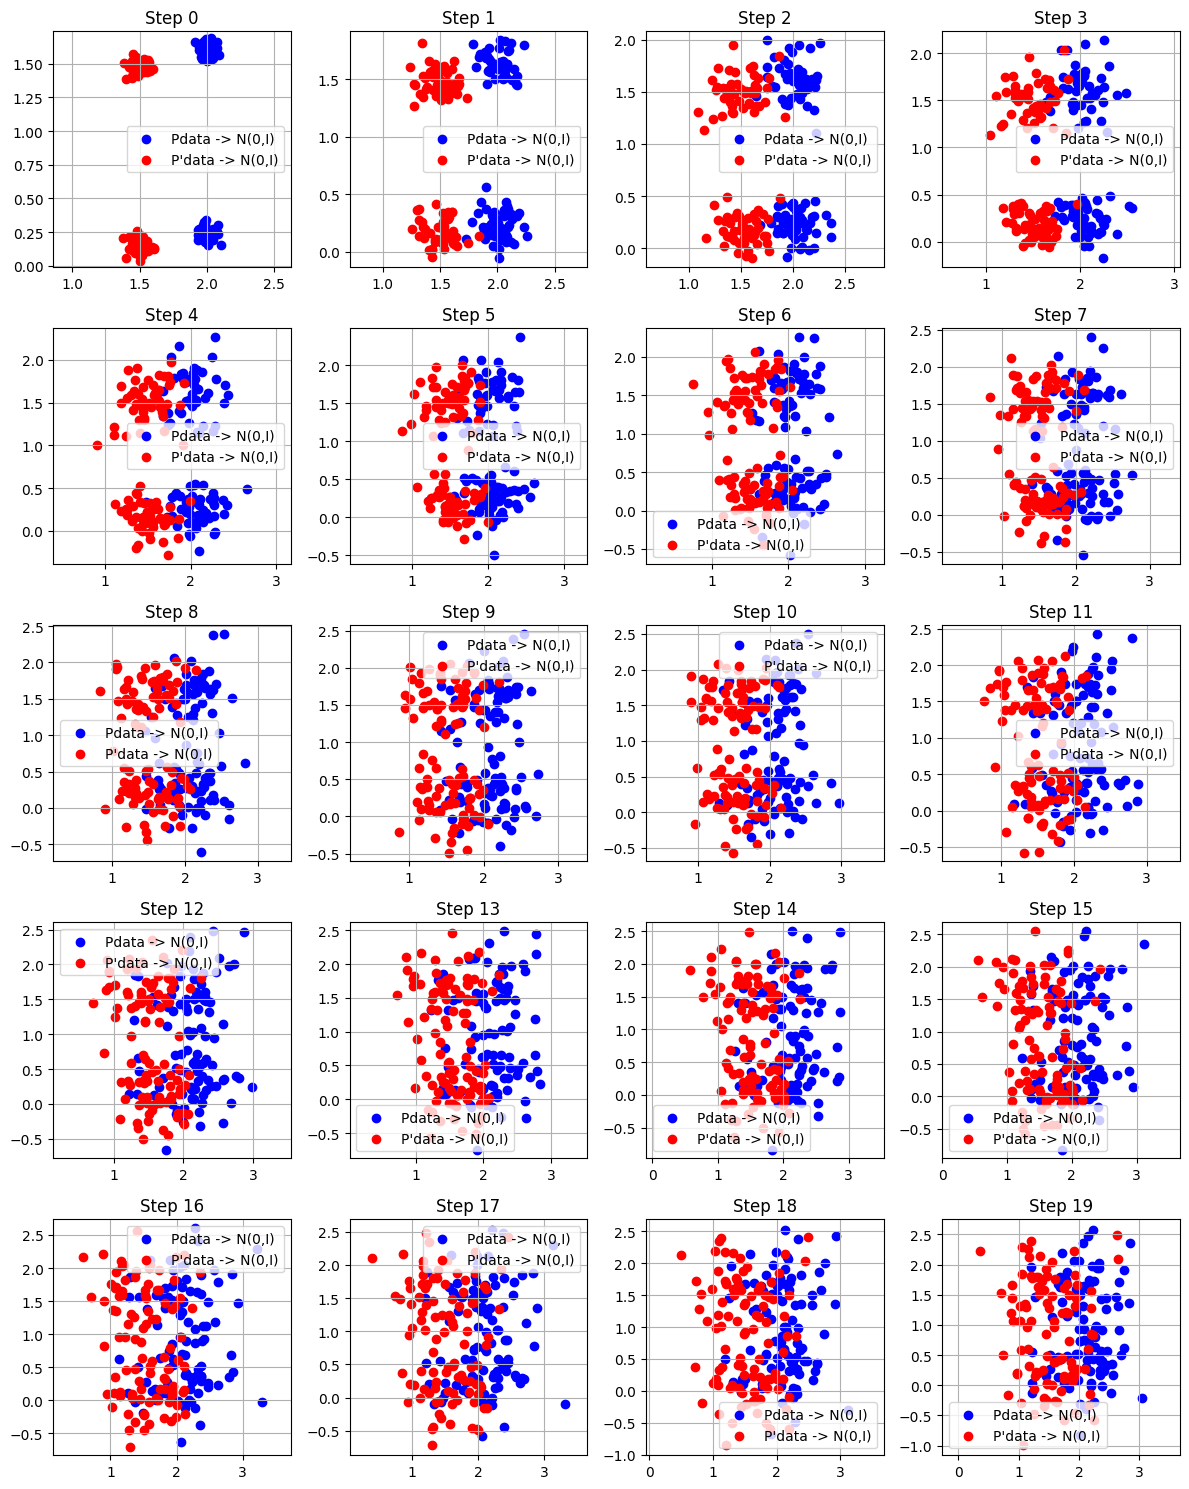

In [ ]:
# JUST TO VISUALIZE FOR FUN (NOT A PART OF PROBLEM)
# plot the X and Y dist
rows = (T + 3) // 4 # rows
plt.figure(figsize=(12, 3 * rows))

for i in range(T):
    plt.subplot(rows, 4, i + 1)
    plt.grid(True)
    plt.scatter(X[i][:100, 0], X[i][:100, 1], color='blue', label='Pdata -> N(0,I)')
    plt.scatter(Y[i][:100, 0], Y[i][:100, 1], color='red', label="P'data -> N(0,I)")
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.title(f"Step {i}")

In [ ]:
def data_sampler(num_points):
  cluster1_mean = (2, 1.6)
  cluster1_var = 0.002

  cluster2_mean = (2, 0.25)
  cluster2_var = 0.002

  cluster_1_size = num_points // 2
  cluster_2_size = num_points // 2

  # sample points for each cluster
  cluster1 = np.random.multivariate_normal(cluster1_mean, np.eye(2) * cluster1_var, cluster_1_size)
  cluster2 = np.random.multivariate_normal(cluster2_mean, np.eye(2) * cluster2_var, cluster_2_size)

  # combine the clusters
  pdata_np = np.concatenate([cluster1, cluster2])
  np.random.shuffle(pdata_np)
  pdata = torch.tensor(pdata_np, dtype=torch.float32)

  # distribution2 is distribution1 but shifted
  pdata_prime_np = pdata_np - np.array([cluster1_mean[0]/4, cluster2_mean[1]/2])
  np.random.shuffle(pdata_prime_np)
  pdata_prime = torch.tensor(pdata_prime_np, dtype=torch.float32)
  return pdata, pdata_prime

In [ ]:
class DiffusionModel(torch.nn.Module):
    def __init__(self, input_size=2):
        super(DiffusionModel, self).__init__()
        self.layer1 = self.layer(input_size, 64)
        self.layer2 = self.layer(64, 128)
        self.layer3 = torch.nn.Linear(128, 2)

    def layer(self, in_features, out_features):
        return torch.nn.Sequential(
            torch.nn.Linear(in_features, out_features),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

In [ ]:
# Okay?
T=20
gamma=2/T
lr = 0.0001
n_epochs = 40 #4
batch_size = 1000
num_points = 10000
optimizer = torch.optim.Adam
loss = torch.nn.MSELoss

In [ ]:
def one_hot_encode(t, T, n):
  one_hot = np.zeros((n, T))
  one_hot[np.arange(n), t] = 1
  return one_hot

In [ ]:
def train_diffusion_model(T,
                          num_points,
                          gamma,
                          n_epochs,
                          batch_size,
                          learning_rate,
                          optimizer_cls,
                          loss_fn_cls,
                          data_sampler,
                          data_type="p_data"):
    # Initialize loss function and model
    loss_fn = loss_fn_cls()
    model = DiffusionModel(input_size=2)  # 2 for x, y, T for time steps + T
    optimizer = optimizer_cls(model.parameters(), lr=learning_rate)

    losses = []
    for epoch in tqdm(range(n_epochs), desc="Training Epochs"):
        model.train()
        epoch_loss = 0

        # Resample the dataset for this epoch
        pdata, pdata_prime = data_sampler(num_points)
        dataset = pdata if data_type == "p_data" else pdata_prime

        for i in range(len(dataset) // batch_size):
            # get the batch
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            X_t = dataset[start_idx:end_idx]

            for t in range(T):
                # One-hot encode t
                t_one_hot = one_hot_encode(t, T, batch_size)
                t_one_hot = torch.tensor(t_one_hot, dtype=torch.float32)

                z = torch.randn_like(X_t)
                X_t_plus_1 = X_t + (gamma * z)

                # Forward
                f_X_t_plus_1 = model(X_t_plus_1)
                loss = loss_fn(f_X_t_plus_1, X_t)

                # Backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

        # Average loss for the epoch
        epoch_loss = epoch_loss / (T * (len(dataset) // batch_size))
        losses.append(epoch_loss)
        tqdm.write(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.6f}")

    # Evaluation: Reverse Diffusion
    X_T = torch.randn((1000, 2))  # X_T ~ N(0, I)
    X_history = [X_T.clone().detach()]
    X_t = X_T

    for t in reversed(range(T)):

        # Reverse step
        X_t = model(X_t_plus_1)
        X_history.append(X_t.clone().detach())

    return model, losses, X_history

p_model, p_losses, history = train_diffusion_model(T, num_points, gamma, n_epochs, batch_size, lr, optimizer, loss, data_sampler, "p_data")

Training Epochs:  10%|█         | 1/10 [00:00<00:03,  2.32it/s]

Epoch 1/10, Loss: 1.961541


Training Epochs:  20%|██        | 2/10 [00:00<00:03,  2.32it/s]

Epoch 2/10, Loss: 0.510415


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  2.27it/s]

Epoch 3/10, Loss: 0.125636


Training Epochs:  40%|████      | 4/10 [00:01<00:02,  2.33it/s]

Epoch 4/10, Loss: 0.063765


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  2.34it/s]

Epoch 5/10, Loss: 0.027050


Training Epochs:  60%|██████    | 6/10 [00:02<00:01,  2.38it/s]

Epoch 6/10, Loss: 0.010746


Training Epochs:  70%|███████   | 7/10 [00:02<00:01,  2.39it/s]

Epoch 7/10, Loss: 0.007455


Training Epochs:  80%|████████  | 8/10 [00:03<00:00,  2.34it/s]

Epoch 8/10, Loss: 0.006783


Training Epochs:  90%|█████████ | 9/10 [00:03<00:00,  2.40it/s]

Epoch 9/10, Loss: 0.006547


Training Epochs: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

Epoch 10/10, Loss: 0.006374


In [ ]:
p_prime_model, p_prime_losses, prime_history = train_diffusion_model(T, num_points, gamma, n_epochs, batch_size, lr, optimizer, loss, data_sampler, data_type='p_prime_data')

Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.07it/s]

Epoch 1/10, Loss: 0.833963


Training Epochs:  20%|██        | 2/10 [00:00<00:03,  2.02it/s]

Epoch 2/10, Loss: 0.113971


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  2.13it/s]

Epoch 3/10, Loss: 0.026178


Training Epochs:  40%|████      | 4/10 [00:01<00:02,  2.19it/s]

Epoch 4/10, Loss: 0.009269


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  2.22it/s]

Epoch 5/10, Loss: 0.005974


Training Epochs:  60%|██████    | 6/10 [00:02<00:01,  2.01it/s]

Epoch 6/10, Loss: 0.005262


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.88it/s]

Epoch 7/10, Loss: 0.004913


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.77it/s]

Epoch 8/10, Loss: 0.004680


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.69it/s]

Epoch 9/10, Loss: 0.004492


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]

Epoch 10/10, Loss: 0.004362


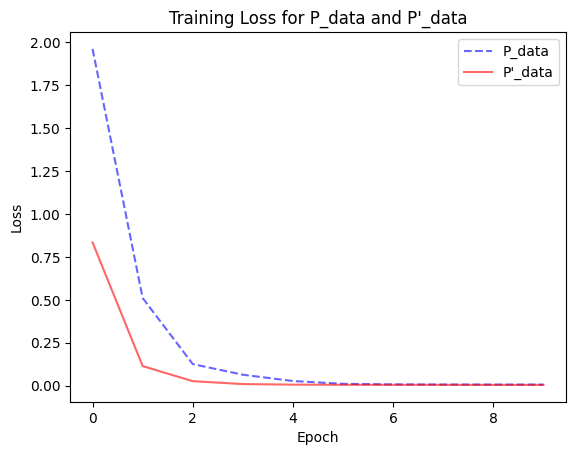

In [ ]:
plt.plot(p_losses, label = "P_data", color='blue', alpha=0.6, linestyle='--')
plt.plot(p_prime_losses, label = "P'_data", color='red', alpha=0.6)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for P_data and P'_data")
plt.show()

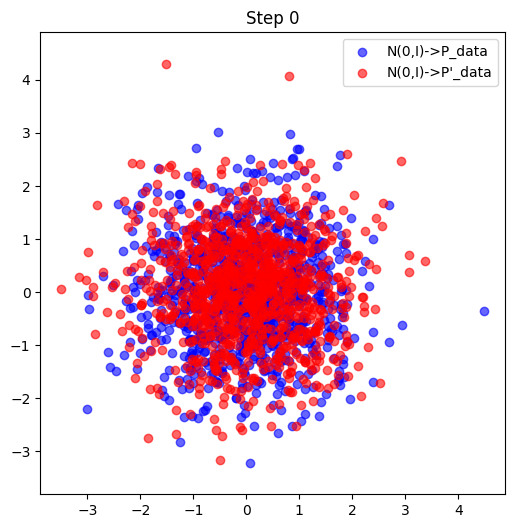

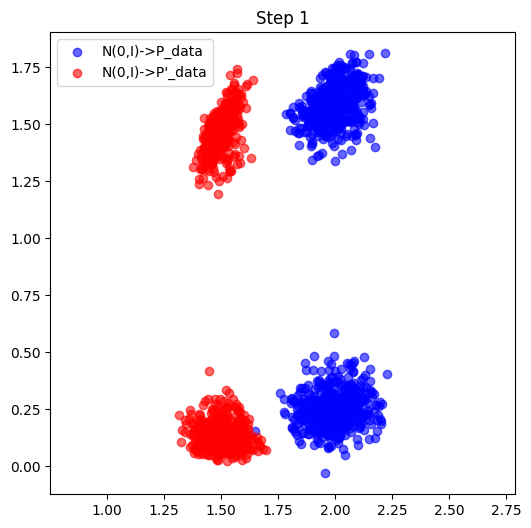

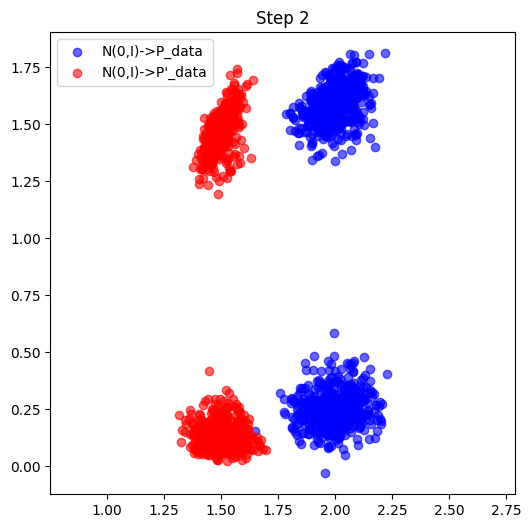

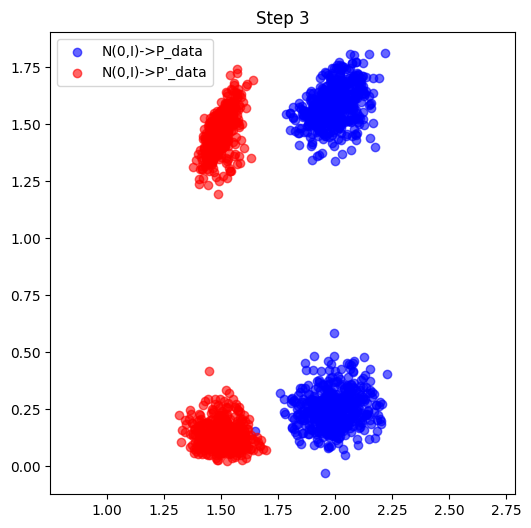

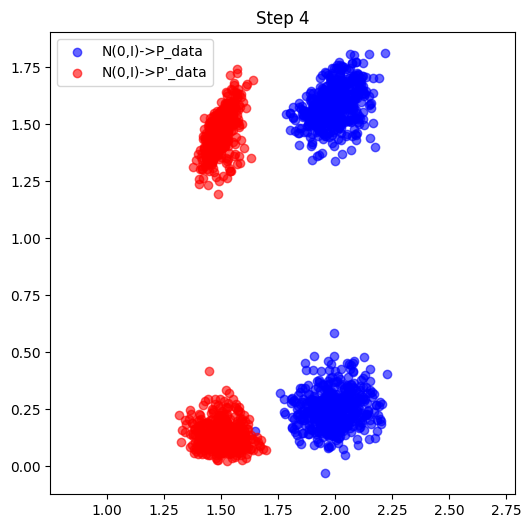

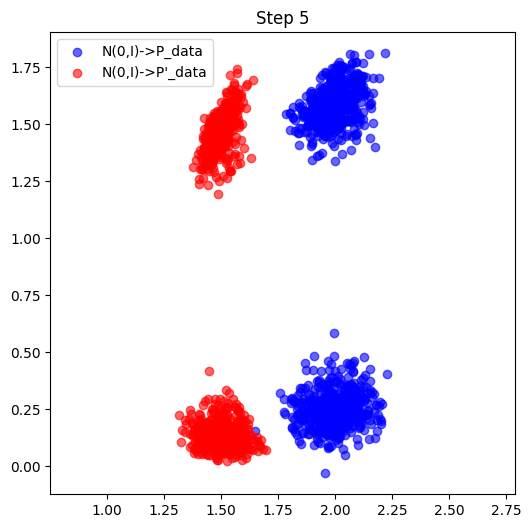

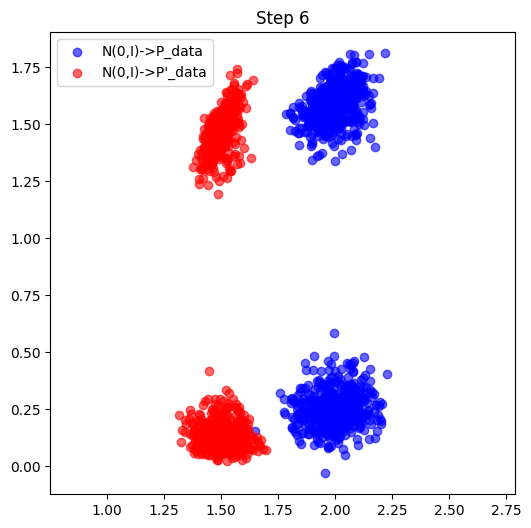

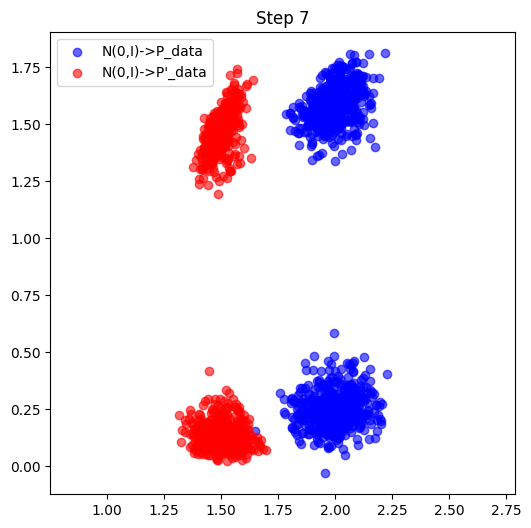

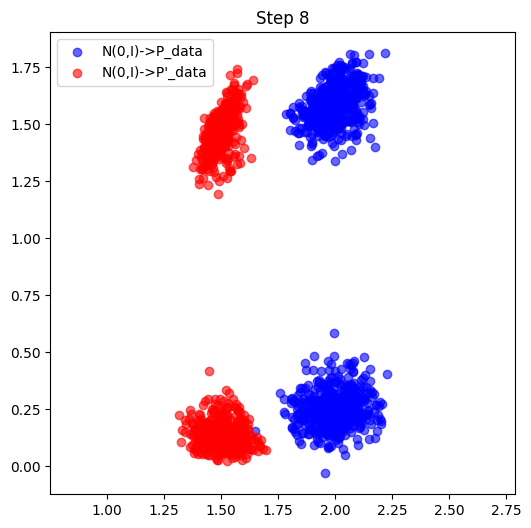

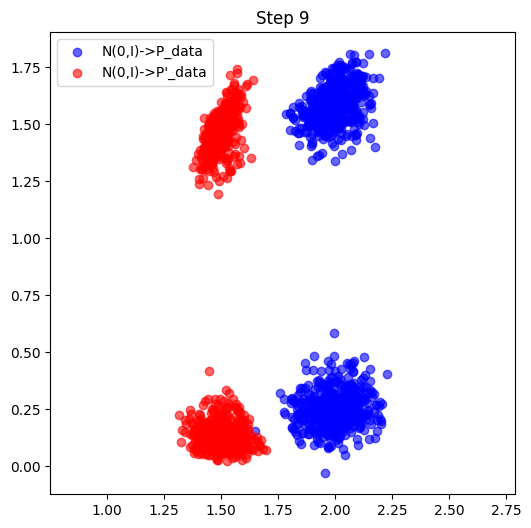

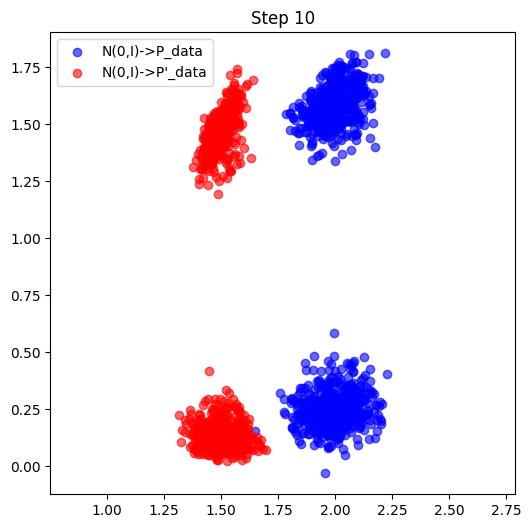

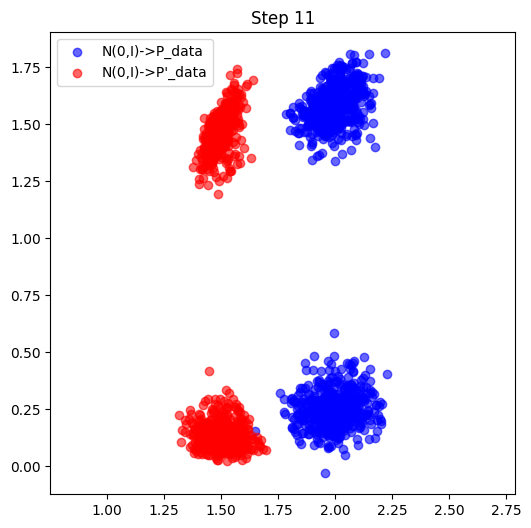

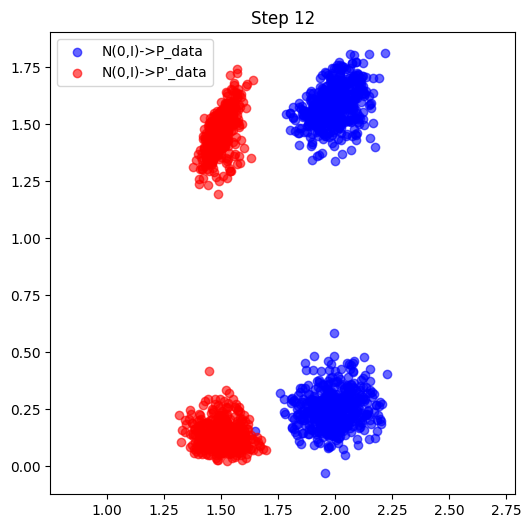

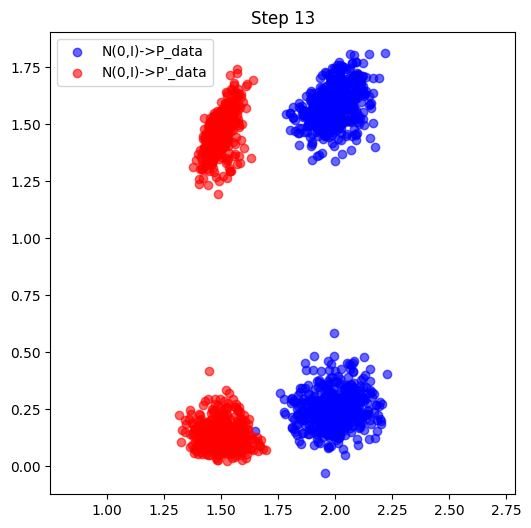

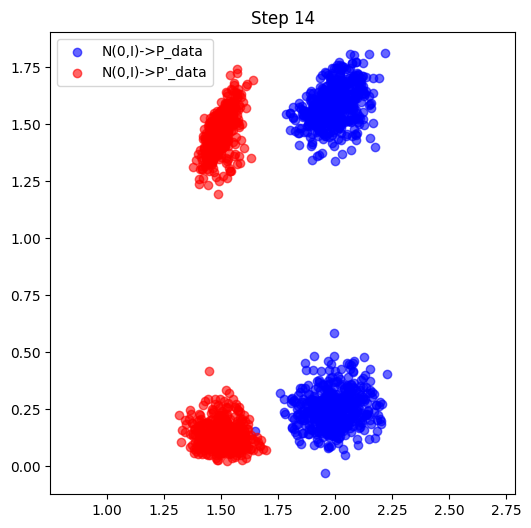

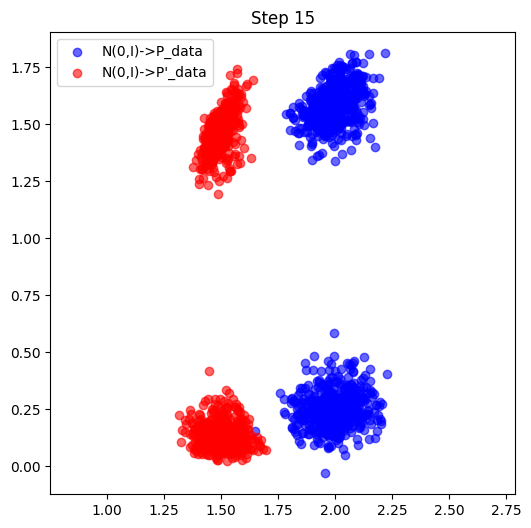

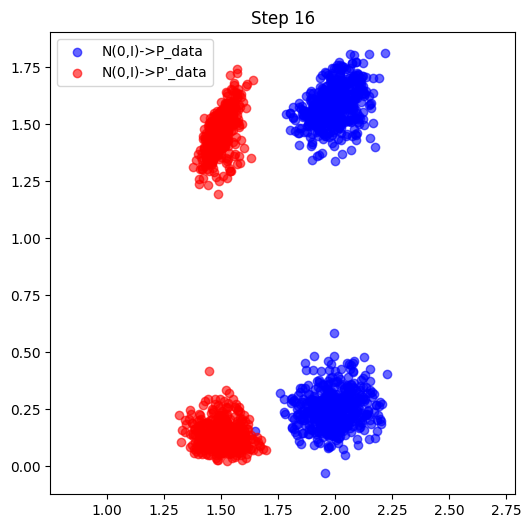

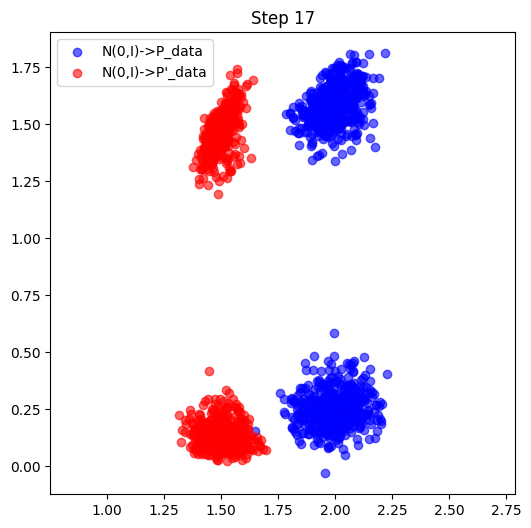

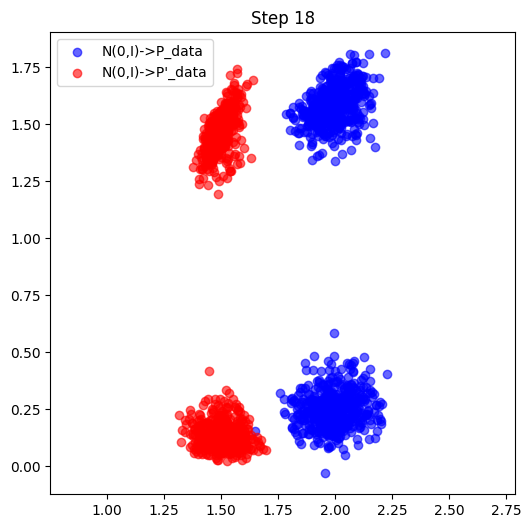

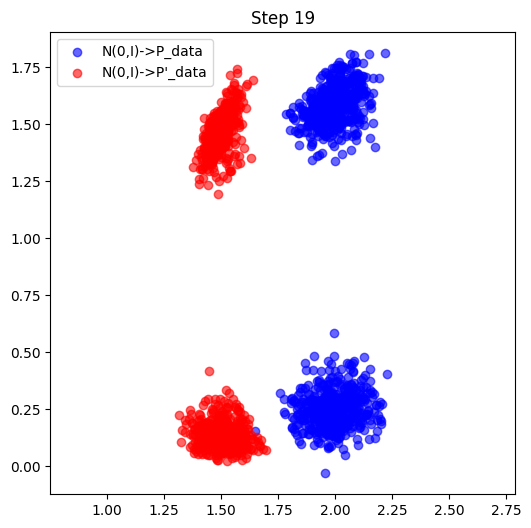

In [ ]:
for i in range(T):
  plt.figure(figsize=(6, 6))
  plt.scatter(history[i][:1000, 0], history[i][:1000, 1], color='blue', alpha=0.6, label='N(0,I)->P_data')
  plt.scatter(prime_history[i][:1000, 0], prime_history[i][:1000, 1], color='red', alpha=0.6, label="N(0,I)->P'_data")
  plt.axis('equal')
  plt.legend()
  plt.title(f"Step {i}")
  plt.show()

### **Problem 3C**

During training:

- Sample points x0 ∼ pdata and apply the backward model b for T steps. Plot the progression of the points.
- Sample points yT ∼ pdata and apply the forward model f for T steps. Plot the progression of the points.

In [ ]:
def evaluate(forward_model, backward_model, T, num_points, epoch):
    # Sample X_0 from pdata, Y_T from p_prime_data
    X_0, Y_T = data_sampler(num_points)
    X_T_history = [X_0.clone().detach()]
    Y_0_history = [Y_T.clone().detach()]
    X_t = X_0
    Y_t = Y_T

    for t in reversed(range(T)):
        # Apply forward model from Y_T, Y_T-1, ..., Y_0
        Y_t = forward_model(Y_t)
        Y_0_history.append(Y_t.clone().detach())

    for t in range(T):
        # Apply backward model from X_0, X_1, ..., X_T
        X_t = backward_model(X_t)
        X_T_history.append(X_t.clone().detach())

    # Every 5th and the last
    steps_to_plot = [0] + [i for i in range(5, T, 5)] + [T - 1]
    n_steps = len(steps_to_plot)

    fig, axes = plt.subplots(nrows=1, ncols=n_steps, figsize=(n_steps * 4, 4), constrained_layout=True)
    for idx, step in enumerate(steps_to_plot):
        ax = axes[idx]
        ax.scatter(X_T_history[step][:, 0], X_T_history[step][:, 1], color='blue', label='Pdata -> N(0,I)', s=10, alpha=0.4)
        ax.scatter(Y_0_history[step][:, 0], Y_0_history[step][:, 1], color='red', label="P'data -> N(0,I)", s=10, alpha=0.4)
        ax.set_xlim(0, 3)
        ax.set_ylim(0, 3)
        ax.set_xticks(np.arange(0, 3, 0.5))
        ax.set_yticks(np.arange(0, 3, 0.5))
        ax.set_title(f"Epoch {epoch}, Step {step}")

    plt.show()

    return X_T_history, Y_0_history


Training Epochs:   0%|          | 0/4 [00:00<?, ?it/s]

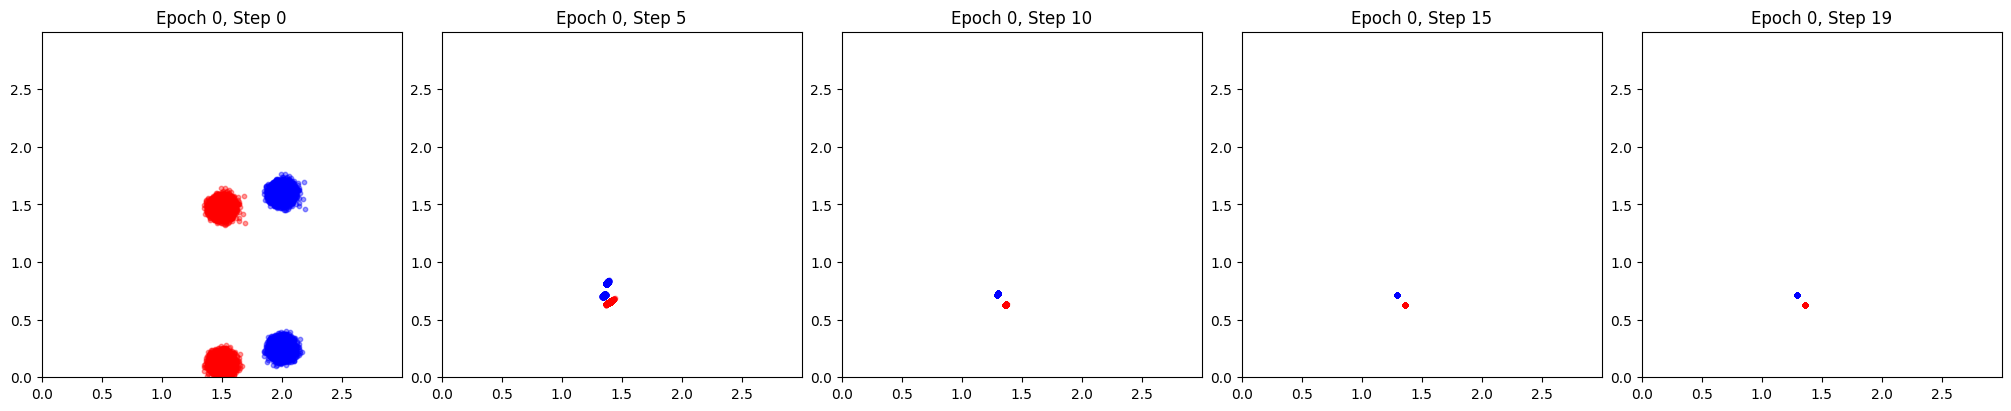

Training Epochs:  25%|██▌       | 1/4 [00:04<00:12,  4.06s/it]

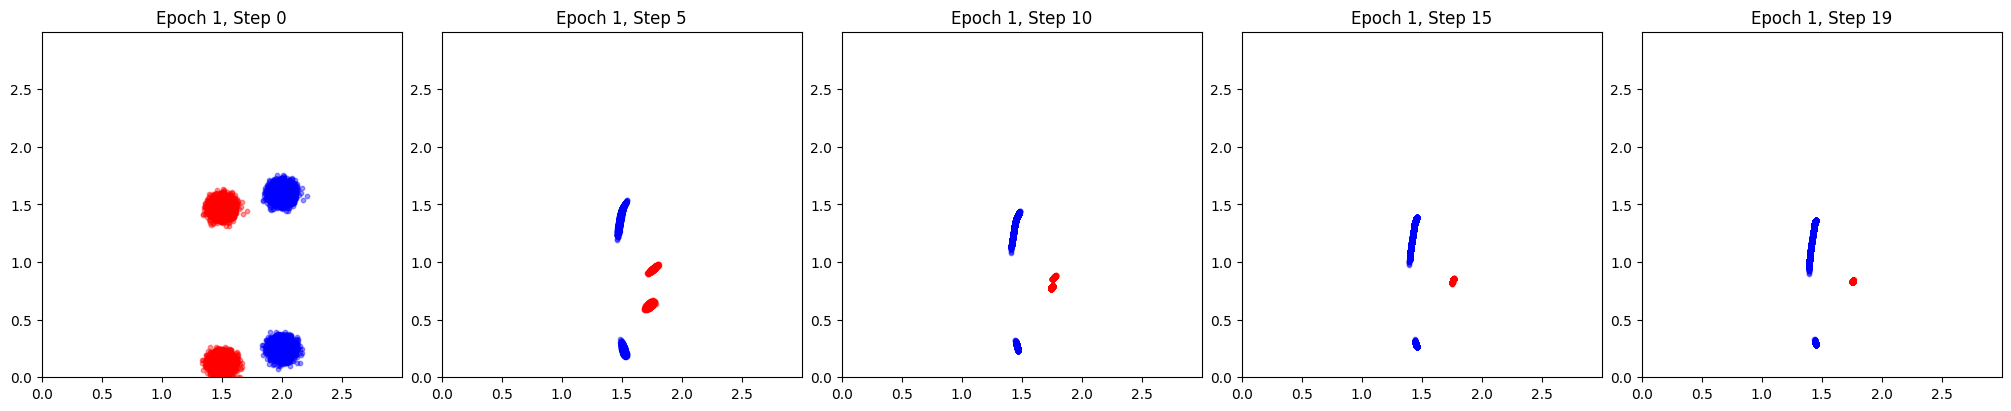

Training Epochs:  50%|█████     | 2/4 [00:09<00:09,  4.82s/it]

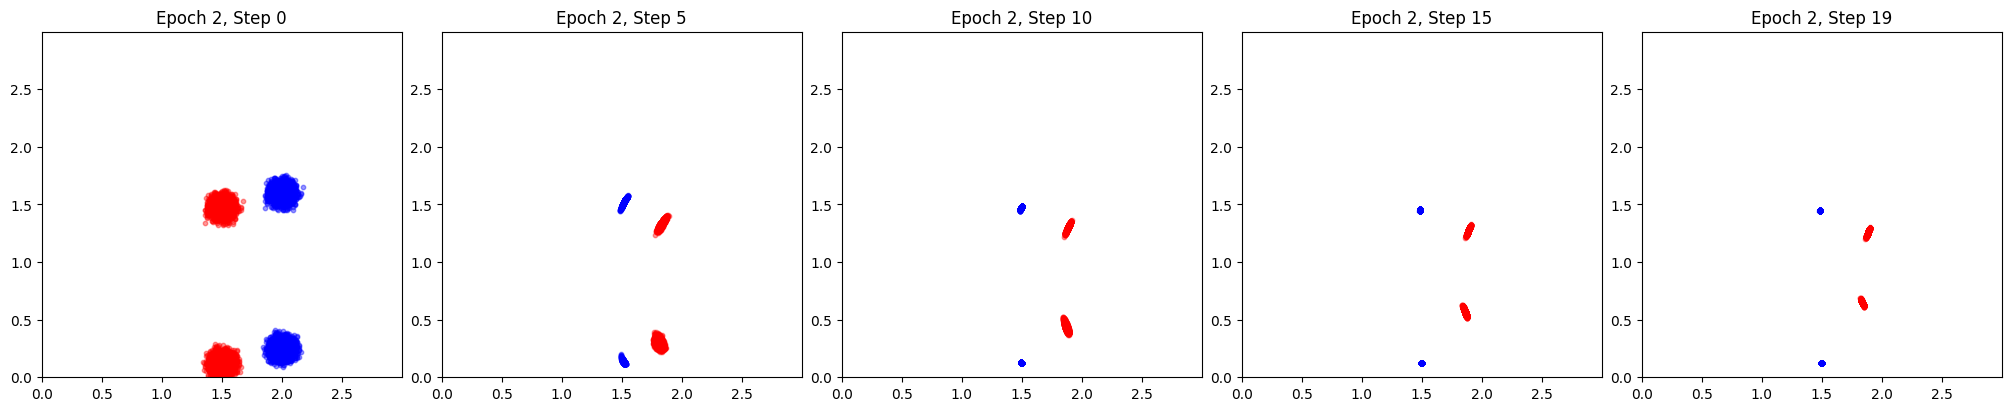

Training Epochs:  75%|███████▌  | 3/4 [00:13<00:04,  4.44s/it]

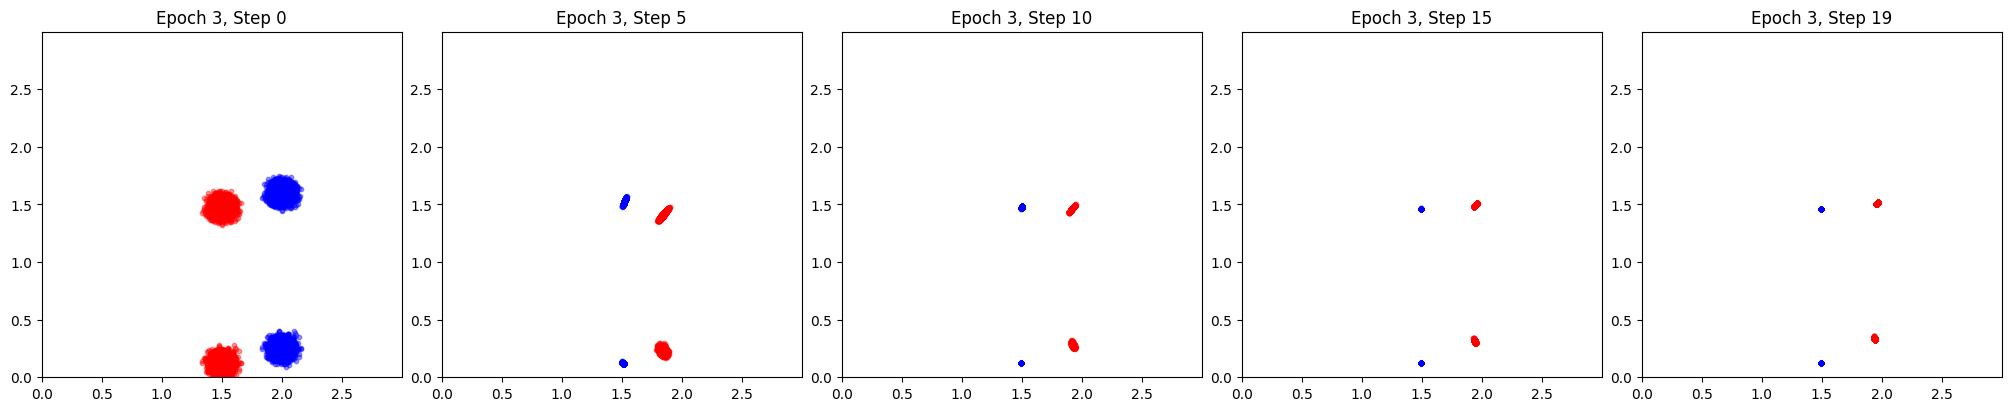

Training Epochs: 100%|██████████| 4/4 [00:17<00:00,  4.27s/it]


In [ ]:
def train_fb_diffusion_models(T,
                            num_points,
                            gamma,
                            n_epochs,
                            batch_size,
                            learning_rate,
                            optimizer_cls,
                            loss_fn_cls):
  loss_fn = loss_fn_cls()
  prime_loss_fn = loss_fn_cls()
  forward_model = DiffusionModel(input_size=2)  # 2 for x, y, T for time steps
  backward_model = DiffusionModel(input_size=2)
  optimizer = optimizer_cls(forward_model.parameters(), lr=learning_rate)
  prime_optimizer = optimizer_cls(backward_model.parameters(), lr=learning_rate)
  pdata, pdata_prime = data_sampler(num_points)

  losses = []
  prime_losses = []
  for epoch in tqdm(range(n_epochs), desc="Training Epochs"):
    forward_model.train()
    backward_model.train()
    epoch_loss = 0
    prime_epoch_loss = 0

    for i in range(len(pdata) // batch_size):
      # Sample X_0 from p_data
      batch_indices = torch.randint(0, pdata.shape[0], (batch_size, ))
      prime_batch_indices = torch.randint(0, pdata_prime.shape[0], (batch_size, ))
      X_t = pdata[batch_indices]
      Y_t = pdata_prime[prime_batch_indices]

      for t in range(T):
        # X_t+1 = X_t + gamma * z where z ~ N(0,I)
        z = torch.randn_like(X_t)
        z_prime = torch.randn_like(Y_t)
        X_t_plus_1 = X_t + (gamma * z)
        Y_t_plus_1 = Y_t + (gamma * z_prime)

        # Forward
        f_X_t_plus_1 = forward_model(X_t_plus_1)
        f_Y_t_plus_1 = backward_model(Y_t_plus_1)
        loss = loss_fn(f_X_t_plus_1, X_t)
        prime_loss = prime_loss_fn(f_Y_t_plus_1, Y_t)

        # Backward
        optimizer.zero_grad()
        prime_optimizer.zero_grad()
        loss.backward()
        prime_loss.backward()
        optimizer.step()
        prime_optimizer.step()
        epoch_loss += loss.item()
        prime_epoch_loss += prime_loss.item()

    # Loss
    epoch_loss = epoch_loss / (T * (len(pdata) // batch_size))
    prime_epoch_loss = prime_epoch_loss / (T * (len(pdata_prime) // batch_size))
    losses.append(epoch_loss)
    prime_losses.append(prime_epoch_loss)

    evaluate(forward_model, backward_model, T, num_points, epoch)

    # plot X_T and Y_0 histories
  return forward_model, backward_model, losses, prime_losses, X_T_history, Y_0_history

forward_model, backward_model, losses, prime_losses, X_T_history, Y_0_history = train_fb_diffusion_models(T, num_points, gamma, n_epochs, batch_size, lr, optimizer, loss)

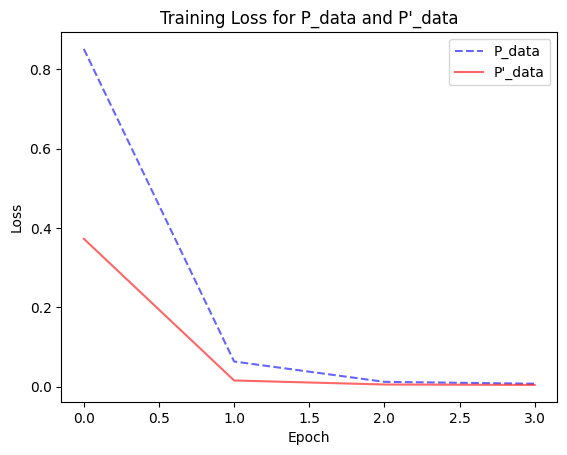

In [ ]:
plt.plot(losses, label = "P_data", color='blue', alpha=0.6, linestyle='--')
plt.plot(prime_losses, label = "P'_data", color='red', alpha=0.6)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for P_data and P'_data")
plt.legend()

### **Extra Credit**

Iteratively train the models together via the Schr¨odinger bridge training as described in class. During training, produce the same plots as described above. What do you notice?